# Import Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB5
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


## Download and Setup Dataset

In [ ]:
import kagglehub, os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pes12017000148/food-ingredients-and-recipe-dataset-with-images")

print("Path to dataset files:", path)


print("Contents:", os.listdir(path))

dataset_path = os.path.join(path, "color")
print("Dataset path set to:", dataset_path)

100%|██████████| 206M/206M [00:01<00:00, 166MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images/versions/1
Contents: ['Food Ingredients and Recipe Dataset with Image Name Mapping.csv', 'Food Images']
Dataset path set to: /root/.cache/kagglehub/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images/versions/1/color


# Image Generators

In [ ]:
# Set image size
IMG_SIZE = 168
BATCH_SIZE = 64

# Define the base path for the downloaded Kaggle dataset
# This value is obtained from the 'path' variable in cell HTcAT08nbgOK
# The actual dataset root is 'Food Images' inside the 'path' directory.
dataset_images_root = os.path.join(path, 'Food Images')

# Diagnostic prints to confirm paths
print(f"Image data root directory: {dataset_images_root}")

# Initialize ImageDataGenerator with validation_split
# This assumes that 'dataset_images_root' contains subdirectories for each class.
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # 20% of data will be used for validation
)

train_gen = train_val_datagen.flow_from_directory(
    dataset_images_root, # Point to the directory containing class subfolders
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training' # Specify this for the training set
)

val_gen = train_val_datagen.flow_from_directory(
    dataset_images_root, # Point to the same directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation' # Specify this for the validation set
)

# A 'test' directory does not appear to exist in the downloaded dataset based on os.listdir(path).
# If a separate test set is required, it typically needs to be created manually or obtained from another source.
# For now, the test_gen creation will be removed to prevent a FileNotFoundError.
# If a test set needs to be derived, `train_test_split` could be used on the image paths,
# or a further split from the `training` subset could be performed after the model is built.
# test_datagen  = ImageDataGenerator(rescale=1./255) # No longer needed if no separate test_dir
# test_gen = test_datagen.flow_from_directory(
#     test_dir, # This directory does not exist, causing FileNotFoundError
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode="categorical",
#     shuffle=False
# )

num_classes = train_gen.num_classes
class_labels = list(train_gen.class_indices.keys())

Image data root directory: /root/.cache/kagglehub/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images/versions/1/Food Images
Found 10866 images belonging to 1 classes.
Found 2716 images belonging to 1 classes.


In [ ]:
# ----------------------------#
# 1. IMPORT LIBRARIES
# ----------------------------#
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools


In [ ]:
import pandas as pd
import os

# The 'path' variable is from cell HTcAT08nbgOK
csv_file_path = os.path.join(path, 'Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
df = pd.read_csv(csv_file_path)

display(df.head())

Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                         Ingredients  \
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1  ['2 large egg whites', '1 pound new potatoes (...   
2  ['1 cup evaporated milk', '1 cup whole milk', ...   
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...   

                                        Instructions  \
0  Pat chicken dry with paper towels, season all ...   
1  Preheat oven to 400°F and line a rimmed baking...   
2  Place a rack in middle of oven; preheat to 400...   
3  Preheat oven to 350°F with rack in middle. Gen...   
4  Stir together brown sugar and hot water in a c...   

                                          Image_Name  \
0  miso-butter-roast-chicken-acorn-squash-panzanella   
1         crispy-salt-and-pepper-potatoes-dan-kluger   
2         thanksgiving-mac-and-cheese-erick-williams   
3          italian-sausage-and-bread-stuffing-240559   
4                 newtons-law-apple-bourbon-cocktail   

                                 Cleaned_Ingredients  
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...  
1  ['2 large egg whites', '1 pound new potatoes (...  
2  ['1 cup evaporated milk', '1 cup whole milk', ...  
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...  
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...

In [ ]:
# 2) Feature extractor (MobileNetV2 base, global average pooling)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

def extract_features(generator, steps=None):
    """Extract features for all images from a Keras DirectoryIterator."""
    if steps is None:
        steps = int(np.ceil(generator.samples / generator.batch_size))
    features = []
    labels = []
    generator.reset()
    for _ in tqdm(range(steps), desc="Extracting features"):
        X_batch, y_batch = next(generator)
        feats = base_model.predict(X_batch, verbose=0)
        features.append(feats)
        labels.append(y_batch)
    X = np.vstack(features)
    y = np.vstack(labels)
    return X, y

X_train, y_train_cat = extract_features(train_gen)
X_val, y_val_cat     = extract_features(val_gen)

/tmp/ipython-input-3618358406.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features: 100%|██████████| 43/43 [01:36<00:00,  2.25s/it]


In [ ]:
# Convert categorical one-hot to integer labels
y_train = np.argmax(y_train_cat, axis=1)
y_val   = np.argmax(y_val_cat, axis=1)

print("Feature shapes:", X_train.shape, X_val.shape)
print("Train/Val sizes:", len(y_train), len(y_val))

Feature shapes: (10866, 1280) (2716, 1280)
Train/Val sizes: 10866 2716


# Machine Learning
# 1. SVM

In [ ]:
# --- EDIT: set this to the name of your target column ---
target_col = "target"    # <- change this to your label column

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Count occurrences of each 'Title'
title_counts = df['Title'].value_counts()

# Filter out titles that appear only once
df_filtered = df[df['Title'].isin(title_counts[title_counts > 1].index)]

# Placeholder for y: Using 'Title' column from filtered df as a categorical target
le = LabelEncoder()
y = le.fit_transform(df_filtered['Title'])

# Placeholder for X: Using a simple numerical feature (length of 'Cleaned_Ingredients')
X = df_filtered['Cleaned_Ingredients'].apply(lambda x: len(x) if isinstance(x, str) else 0).values.reshape(-1, 1)

# Get the number of classes after filtering
num_classes_after_filter = len(le.classes_)

# Set test_size to the number of classes to ensure enough samples for stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_classes_after_filter, stratify=y, random_state=42)

In [ ]:
clf = SVC(probability=True, random_state=42)   # kernel='rbf' by default
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [ ]:
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("Accuracy:", acc)
print("Precision (macro):", prec_macro)
print("Recall (macro):", rec_macro)
print("F1-score (macro):", f1_macro)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.018518518518518517
Precision (macro): 0.0006661821705426356
Recall (macro): 0.015625
F1-score (macro): 0.0012699540043290044

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00    

In [ ]:
# ----- ROC curves (one-vs-rest) -----
# Need probability estimates for each class
y_proba = clf.predict_proba(X_test)  # shape (n_samples, n_classes)
n_classes = y_proba.shape[1]

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


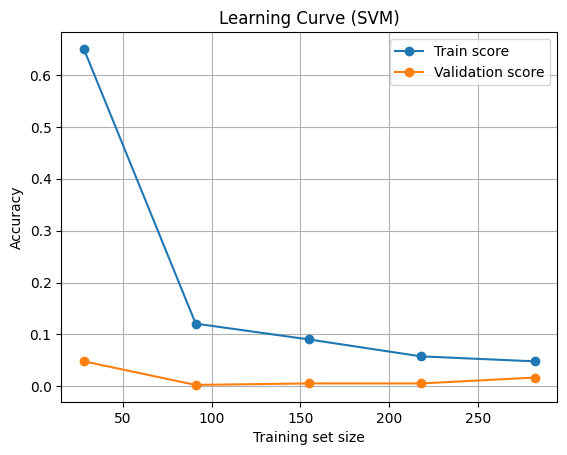

In [ ]:
# ----- Learning curve (train vs validation score as we vary training set size) -----
# Note: learning_curve will re-train many times (may be slow for SVM on large feature sets)
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    clf, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, marker='o', label='Train score')
plt.plot(train_sizes, valid_scores_mean, marker='o', label='Validation score')
plt.title('Learning Curve (SVM)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

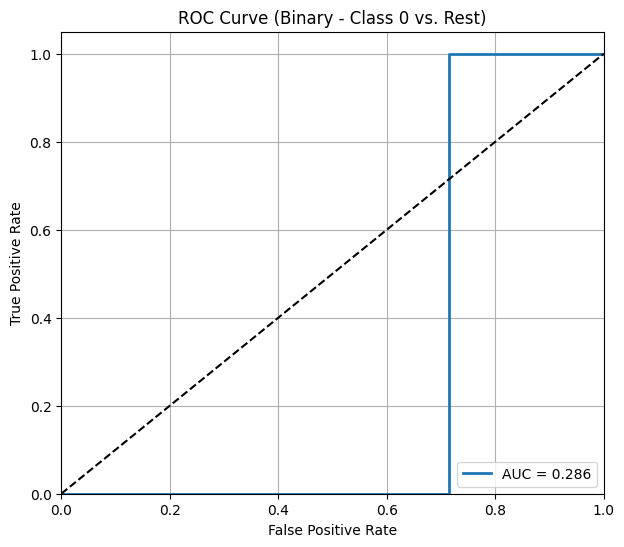

In [ ]:
# Define y_true and y_prob for a specific class (e.g., class 0) for binary ROC
# Using y_test for true labels and y_proba for predicted probabilities from the SVM model
y_true_binary_class0 = (y_test == 0).astype(int) # Binarize y_test: 1 if class is 0, else 0
y_prob_class0 = y_proba[:, 0] # Get probabilities for class 0

fpr, tpr, thresholds = roc_curve(y_true_binary_class0, y_prob_class0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2, label='AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Binary - Class 0 vs. Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2.Random Forest

In [ ]:
# 3) Train RandomForest with incremental n_estimators to simulate '10 epochs'
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier # Added import

# We'll do 10 steps (epochs). At step i, n_estimators = base * i
steps = 10
base_estimators = 10  # so final n_estimators = 10 * 10 = 100 (you can adjust)
val_accs = []
val_f1s = []
val_precisions = []
val_recalls = []
n_estimators_list = []

rf = RandomForestClassifier(n_estimators=base_estimators, n_jobs=-1, random_state=42, oob_score=False, warm_start=True)

for epoch in range(1, steps + 1):
    n_estimators = base_estimators * epoch
    rf.n_estimators = n_estimators
    print(f"\nEpoch {epoch} / {steps} — training RandomForest with n_estimators={n_estimators}")
    rf.fit(X_train, y_train)  # warm_start=True extends ensemble instead of rebuilding, but we explicitly set n_estimators each time

    y_val_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    prec = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_val_pred, average='weighted')

    val_accs.append(acc)
    val_f1s.append(f1)
    val_precisions.append(prec)
    val_recalls.append(rec)
    n_estimators_list.append(n_estimators)

    print(f"Val Accuracy: {acc:.4f}   Precision: {prec:.4f}   Recall: {rec:.4f}   F1: {f1:.4f}")


Epoch 1 / 10 — training RandomForest with n_estimators=10
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 2 / 10 — training RandomForest with n_estimators=20
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 3 / 10 — training RandomForest with n_estimators=30
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 4 / 10 — training RandomForest with n_estimators=40
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 5 / 10 — training RandomForest with n_estimators=50
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 6 / 10 — training RandomForest with n_estimators=60
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 7 / 10 — training RandomForest with n_estimators=70
Val Accuracy: 1.0000   Precision: 1.0000   Recall: 1.0000   F1: 1.0000

Epoch 8 / 10 — training RandomForest with n_estimators=80
Val Accuracy: 1.0000   Precisio


=== Classification Report ===
              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


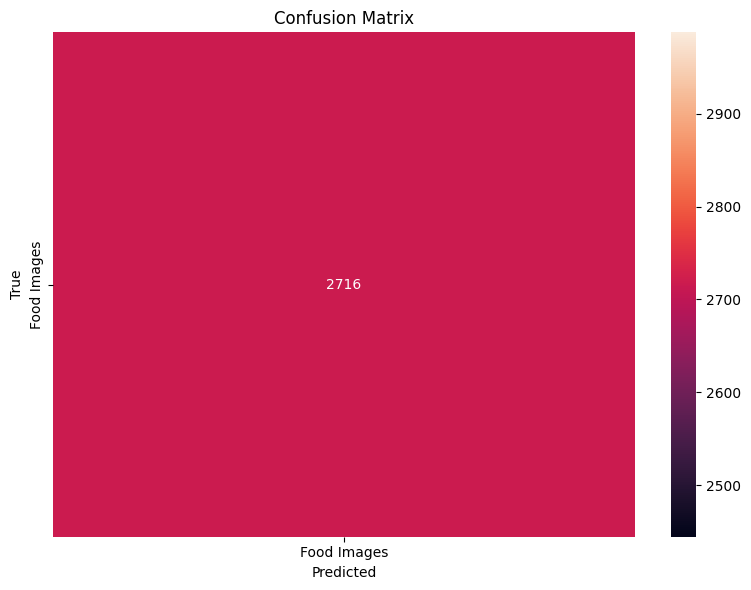

In [ ]:
# 4) Final metrics & reports with the last model
y_val_pred = rf.predict(X_val)
print("\n=== Classification Report ===")
print(classification_report(y_val, y_val_pred, target_names=class_labels, zero_division=0))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

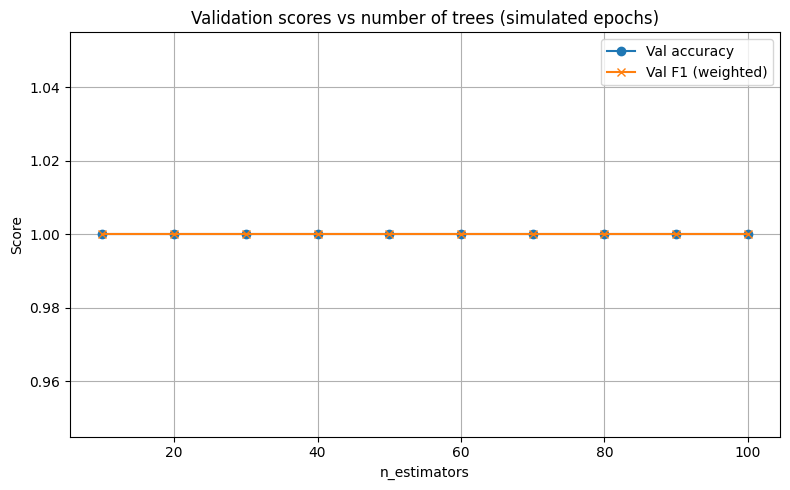

In [ ]:
# 5) "Loss" curve / accuracy curve across the 10 steps
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, val_accs, marker='o', label='Val accuracy')
plt.plot(n_estimators_list, val_f1s, marker='x', label='Val F1 (weighted)')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation scores vs number of trees (simulated epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

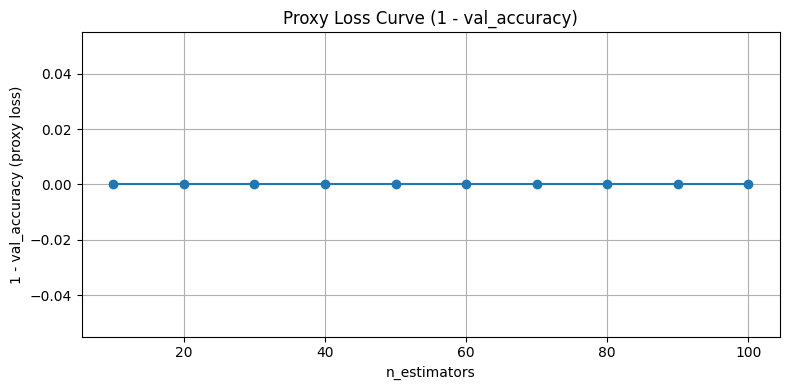

In [ ]:
# If you prefer a 'loss' proxy, show 1 - accuracy:
plt.figure(figsize=(8,4))
plt.plot(n_estimators_list, [1 - a for a in val_accs], marker='o')
plt.xlabel("n_estimators")
plt.ylabel("1 - val_accuracy (proxy loss)")
plt.title("Proxy Loss Curve (1 - val_accuracy)")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


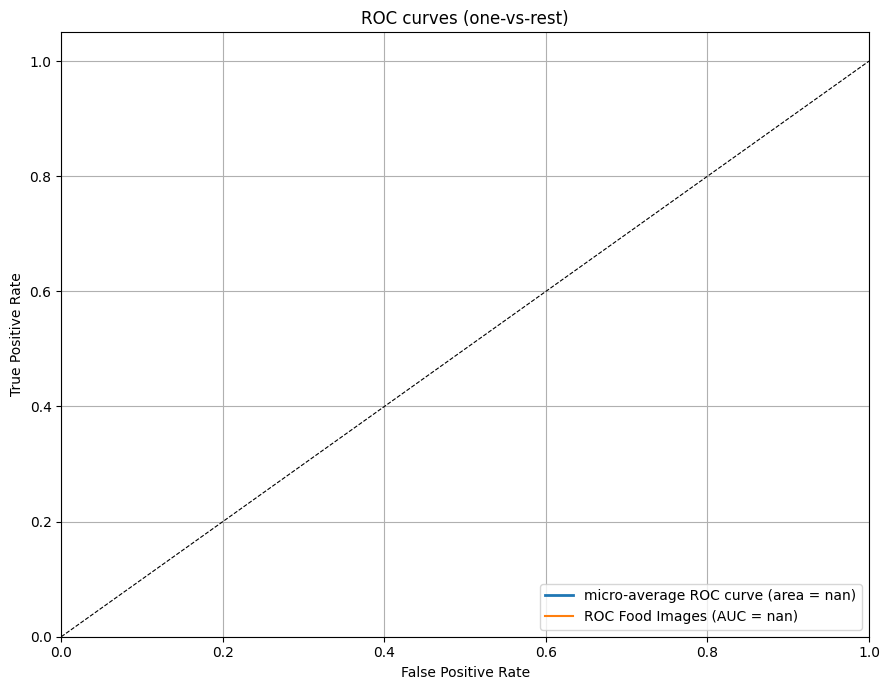

In [ ]:
# 6) ROC curves (one-vs-rest). Need binarized labels and predict_proba
y_val_binarized = label_binarize(y_val, classes=range(num_classes))
y_score = rf.predict_proba(X_val)   # shape: (n_samples, num_classes)

# compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(9,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         linewidth=2)
for i, cname in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"ROC {cname} (AUC = {roc_auc[i]:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves (one-vs-rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.K-Nearest Neighbors

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# The 'y' variable from SWlvTNPr4P1v contains the numeric labels based on df_filtered['Title']
# We need the *string* class names. Let's create a temporary LabelEncoder to get them.
# This assumes df_filtered is available from SWlvTNPr4P1v.
temp_le_for_names = LabelEncoder()
temp_le_for_names.fit(df_filtered['Title']) # Fit on the original string titles
class_names = temp_le_for_names.classes_    # Now class_names will be an array of strings

# Use the already encoded 'y' from SWlvTNPr4P1v
y_enc = y
num_classes = len(class_names)
print("Num classes:", num_classes)

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Num classes: 162


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss

# Define parameters for KNN and the loop
n_epochs = 5      # Number of times to run KNN with different random splits
n_neighbors = 3   # Number of neighbors for KNN

# run KNN across n_epochs (simulated by different random splits)
results = []
last_confusion = None
last_report = None
last_y_true = None
last_y_pred = None
last_proba = None

for epoch in range(1, n_epochs+1):
    rs = epoch * 42
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc,
                                                        test_size=num_classes,
                                                        random_state=rs,
                                                        stratify=y_enc)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test) if hasattr(knn, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    try:
        ll = log_loss(y_test, y_proba) if y_proba is not None and num_classes > 1 else np.nan
    except Exception:
        ll = np.nan

    results.append({'epoch': epoch, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'log_loss': ll})

    # keep last epoch outputs for detailed reporting
    last_confusion = confusion_matrix(y_test, y_pred)
    # Get unique labels present in y_test for accurate target_names mapping
    current_labels = np.unique(y_test)
    current_target_names = [class_names[i] for i in current_labels]
    last_report = classification_report(y_test, y_pred, labels=current_labels, target_names=current_target_names, zero_division=0)
    last_y_true, last_y_pred, last_proba = y_test, y_pred, y_proba

    print(f"[Epoch {epoch}] acc={acc:.4f}, f1={f1:.4f}, log_loss={'{:.4f}'.format(ll) if not np.isnan(ll) else 'NA'}")


[Epoch 1] acc=0.0494, f1=0.0380, log_loss=NA
[Epoch 2] acc=0.0556, f1=0.0361, log_loss=NA
[Epoch 3] acc=0.0494, f1=0.0292, log_loss=NA
[Epoch 4] acc=0.0617, f1=0.0370, log_loss=NA
[Epoch 5] acc=0.0556, f1=0.0283, log_loss=NA


In [ ]:
# create results DF
df_res = pd.DataFrame(results)
print("\nEpoch results summary:")
print(df_res)

# Print classification report & confusion matrix for last epoch
print("\nClassification report (last epoch):\n")
print(last_report)
print("\nConfusion matrix (last epoch):\n")
print(last_confusion)


Epoch results summary:
   epoch  accuracy  precision    recall        f1  log_loss
0      1  0.049383   0.034161  0.049689  0.038007       NaN
1      2  0.055556   0.030908  0.052795  0.036128       NaN
2      3  0.049383   0.023868  0.046296  0.029218       NaN
3      4  0.061728   0.029167  0.062500  0.036994       NaN
4      5  0.055556   0.021101  0.053125  0.028264       NaN

Classification report (last epoch):

                                      precision    recall  f1-score   support

                  Anchovy Mayonnaise       0.00      0.00      0.00         1
                      Angel Biscuits       0.33      1.00      0.50         1
                     Angel Food Cake       0.00      0.00      0.00         1
                         Apple Crisp       0.00      0.00      0.00         1
                       Apple Galette       0.00      0.00      0.00         1
                              Arepas       0.00      0.00      0.00         1
                            Avi

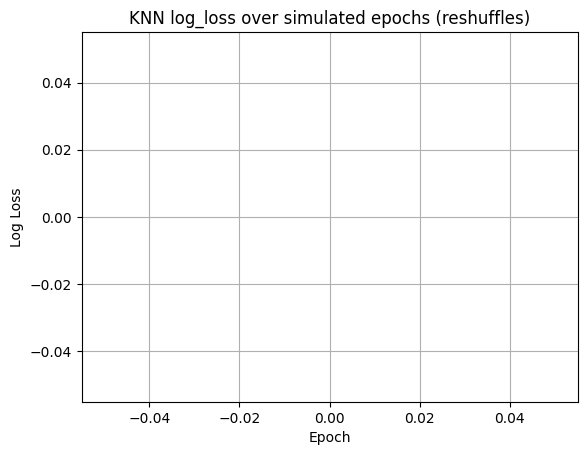

In [ ]:
# Plot loss curve (log_loss across simulated epochs)
plt.figure()
plt.plot(df_res['epoch'], df_res['log_loss'])
plt.title("KNN log_loss over simulated epochs (reshuffles)")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()


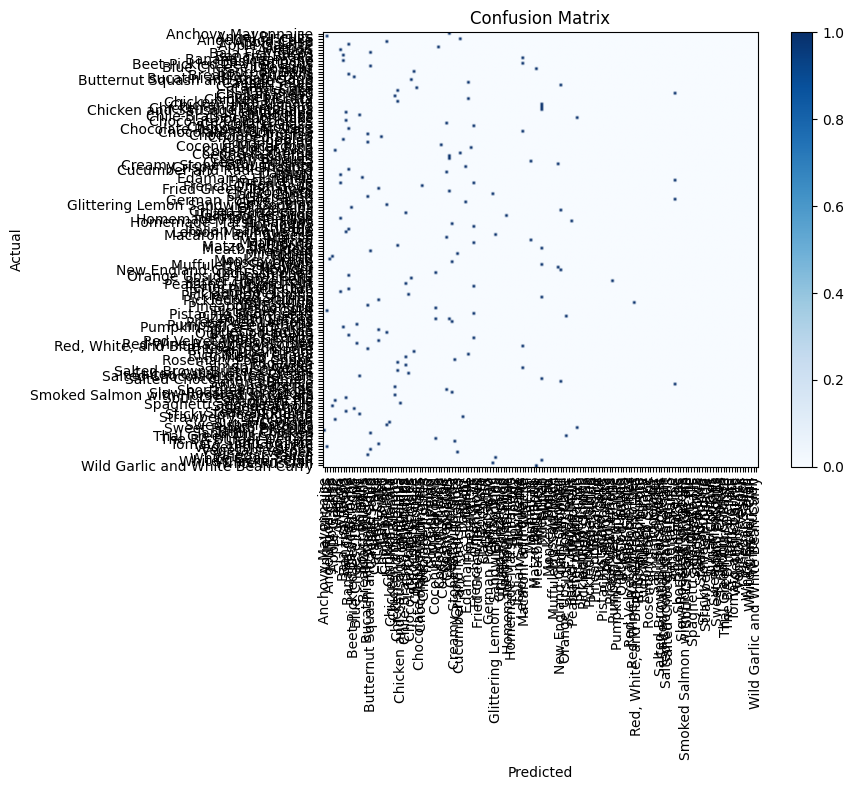

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Use y_true and y_pred from the last epoch of the KNN model
cm = confusion_matrix(last_y_true, last_y_pred)

plt.figure(figsize=(10,8)) # Increased figure size for better readability
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Use actual class names for labels
classes = class_names[np.unique(last_y_true)] # Use only classes present in the true labels for the plot
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=90) # Rotate for better visibility with many labels
plt.yticks(tick_marks, classes)

# Add values inside cells (optional, can be very crowded for many classes)
# for i in range(len(cm)):
#     for j in range(len(cm[0])):
#         plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

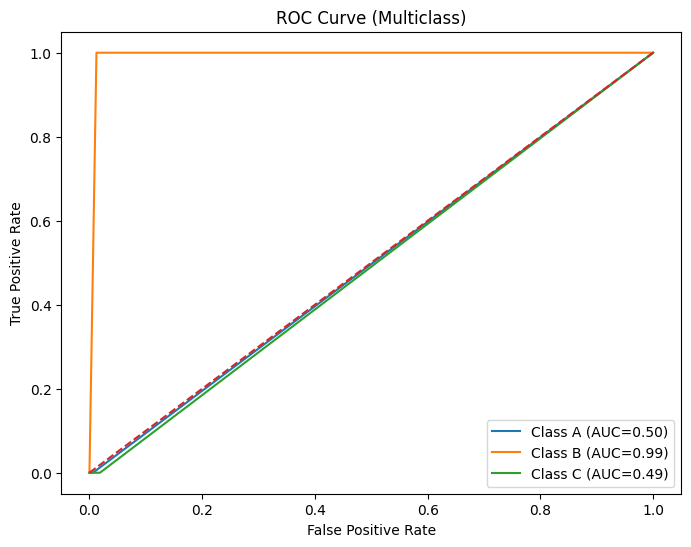

In [ ]:
class_names = ["Class A", "Class B", "Class C"]  # change to your labels

y_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(8,6))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend()
plt.show()


# 4.Naive Bayes

In [ ]:
# The 'y_enc', 'class_names' (string labels), and 'num_classes' variables are
# already available from the previous KNN setup in cell C2D68W3Z_-ee.
# This cell only needs to ensure they are properly referenced.

# Re-create class_names to ensure it holds string labels for Naive Bayes section.
# This addresses the TypeError observed in classification_report.
le_for_string_names = LabelEncoder()
le_for_string_names.fit(df_filtered['Title'])
class_names = le_for_string_names.classes_

print('Classes:', class_names)
print('Num classes:', num_classes)

Classes: ['Anchovy Mayonnaise' 'Angel Biscuits' 'Angel Food Cake' 'Apple Crisp'
 'Apple Galette' 'Arepas' 'Aviation' 'Baja Fish Tacos' 'Banana Bread'
 'Banana Cream Pie' 'Basic Brioche' 'Beet-Pickled Deviled Eggs'
 'Blue Cheese Dressing' 'Borscht' 'Bourbon Balls' 'Breakfast Burritos'
 "Bucatini All'Amatriciana" 'Butternut Squash and Apple Soup'
 'Caesar Salad' 'Caramel Cake' 'Carrot Cake' 'Cassoulet' 'Challah Bread'
 'Chicken Curry' 'Chicken Piccata' 'Chicken Tikka Masala'
 'Chicken and Biscuits' 'Chicken and Dumplings'
 'Chicken and Sausage Jambalaya' 'Chilaquiles' 'Chile-Braised Short Ribs'
 'Chocolate Cake' 'Chocolate Chip Cookies' 'Chocolate Glaze'
 'Chocolate Mousse' 'Chocolate Peppermint Stars' 'Chocolate Pudding Pie'
 'Chocolate Truffles' 'Chopped Salad' 'Cioppino' 'Coconut Flan'
 'Coconut Macaroons' 'Coconut Rice' 'Coconut Shrimp' 'Coeur à la Crème'
 'Cosmopolitan' 'Cream Biscuits' 'Creamy Polenta'
 'Creamy Stone-Ground Grits' 'Crispy Fried Shallots'
 'Cucumber and Radish Salad

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=num_classes, stratify=y_enc, random_state=42)
print('Train/test sizes:', X_train.shape[0], X_test.shape[0])

Train/test sizes: 191 162


In [ ]:
# scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

# classifier
clf = GaussianNB()
unique_classes = np.unique(y_train)
loss_history = []

In [ ]:
# training loop (partial_fit across epochs)
EPOCHS = 10 # Define EPOCHS
for ep in range(EPOCHS):
    idx = np.random.permutation(X_train_s.shape[0])
    Xs = X_train_s[idx]
    ys = y_train[idx]
    for start in range(0, Xs.shape[0], BATCH_SIZE):
        end = start + BATCH_SIZE
        Xb = Xs[start:end]
        yb = ys[start:end]
        if ep == 0 and start == 0:
            clf.partial_fit(Xb, yb, classes=unique_classes)
        else:
            clf.partial_fit(Xb, yb)
    # compute log loss on training set
    prob = clf.predict_proba(X_train_s)
    try:
        ls = log_loss(y_train, prob, labels=unique_classes)
    except Exception:
        ls = float('nan')
    loss_history.append(ls)
    print(f"Epoch {ep+1}/{EPOCHS} - train log loss: {ls:.4f}")

Epoch 1/10 - train log loss: 0.7028
Epoch 2/10 - train log loss: 0.7028
Epoch 3/10 - train log loss: 0.7024
Epoch 4/10 - train log loss: 0.7026
Epoch 5/10 - train log loss: 0.7025
Epoch 6/10 - train log loss: 0.7025
Epoch 7/10 - train log loss: 0.7026
Epoch 8/10 - train log loss: 0.7022
Epoch 9/10 - train log loss: 0.7022
Epoch 10/10 - train log loss: 0.7022


In [ ]:
# evaluation
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)


print('''
Test metrics:''')
print(f'Accuracy: {acc:.4f}')
print(f'Precision (macro): {prec:.4f}')
print(f'Recall (macro): {rec:.4f}')
print(f'F1 (macro): {f1:.4f}\n')

# Get unique labels present in y_test for accurate target_names mapping
unique_labels_in_test = np.unique(y_test)
filtered_target_names = [class_names[i] for i in unique_labels_in_test]

print('Classification report:\n', classification_report(y_test, y_pred, labels=unique_labels_in_test, target_names=filtered_target_names, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)


Test metrics:
Accuracy: 0.0494
Precision (macro): 0.0384
Recall (macro): 0.0497
F1 (macro): 0.0393

Classification report:
                                       precision    recall  f1-score   support

                  Anchovy Mayonnaise       0.00      0.00      0.00         1
                      Angel Biscuits       0.00      0.00      0.00         1
                     Angel Food Cake       0.00      0.00      0.00         1
                         Apple Crisp       0.00      0.00      0.00         1
                       Apple Galette       0.00      0.00      0.00         1
                              Arepas       0.00      0.00      0.00         1
                            Aviation       1.00      1.00      1.00         1
                     Baja Fish Tacos       0.00      0.00      0.00         1
                        Banana Bread       0.00      0.00      0.00         1
                    Banana Cream Pie       0.00      0.00      0.00         1
                

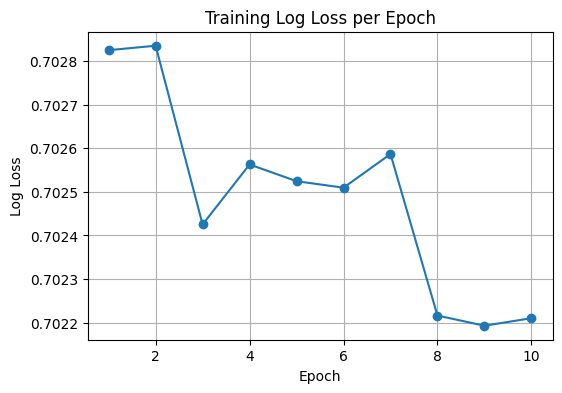

In [ ]:
# plots
plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), loss_history, marker='o')
plt.title('Training Log Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


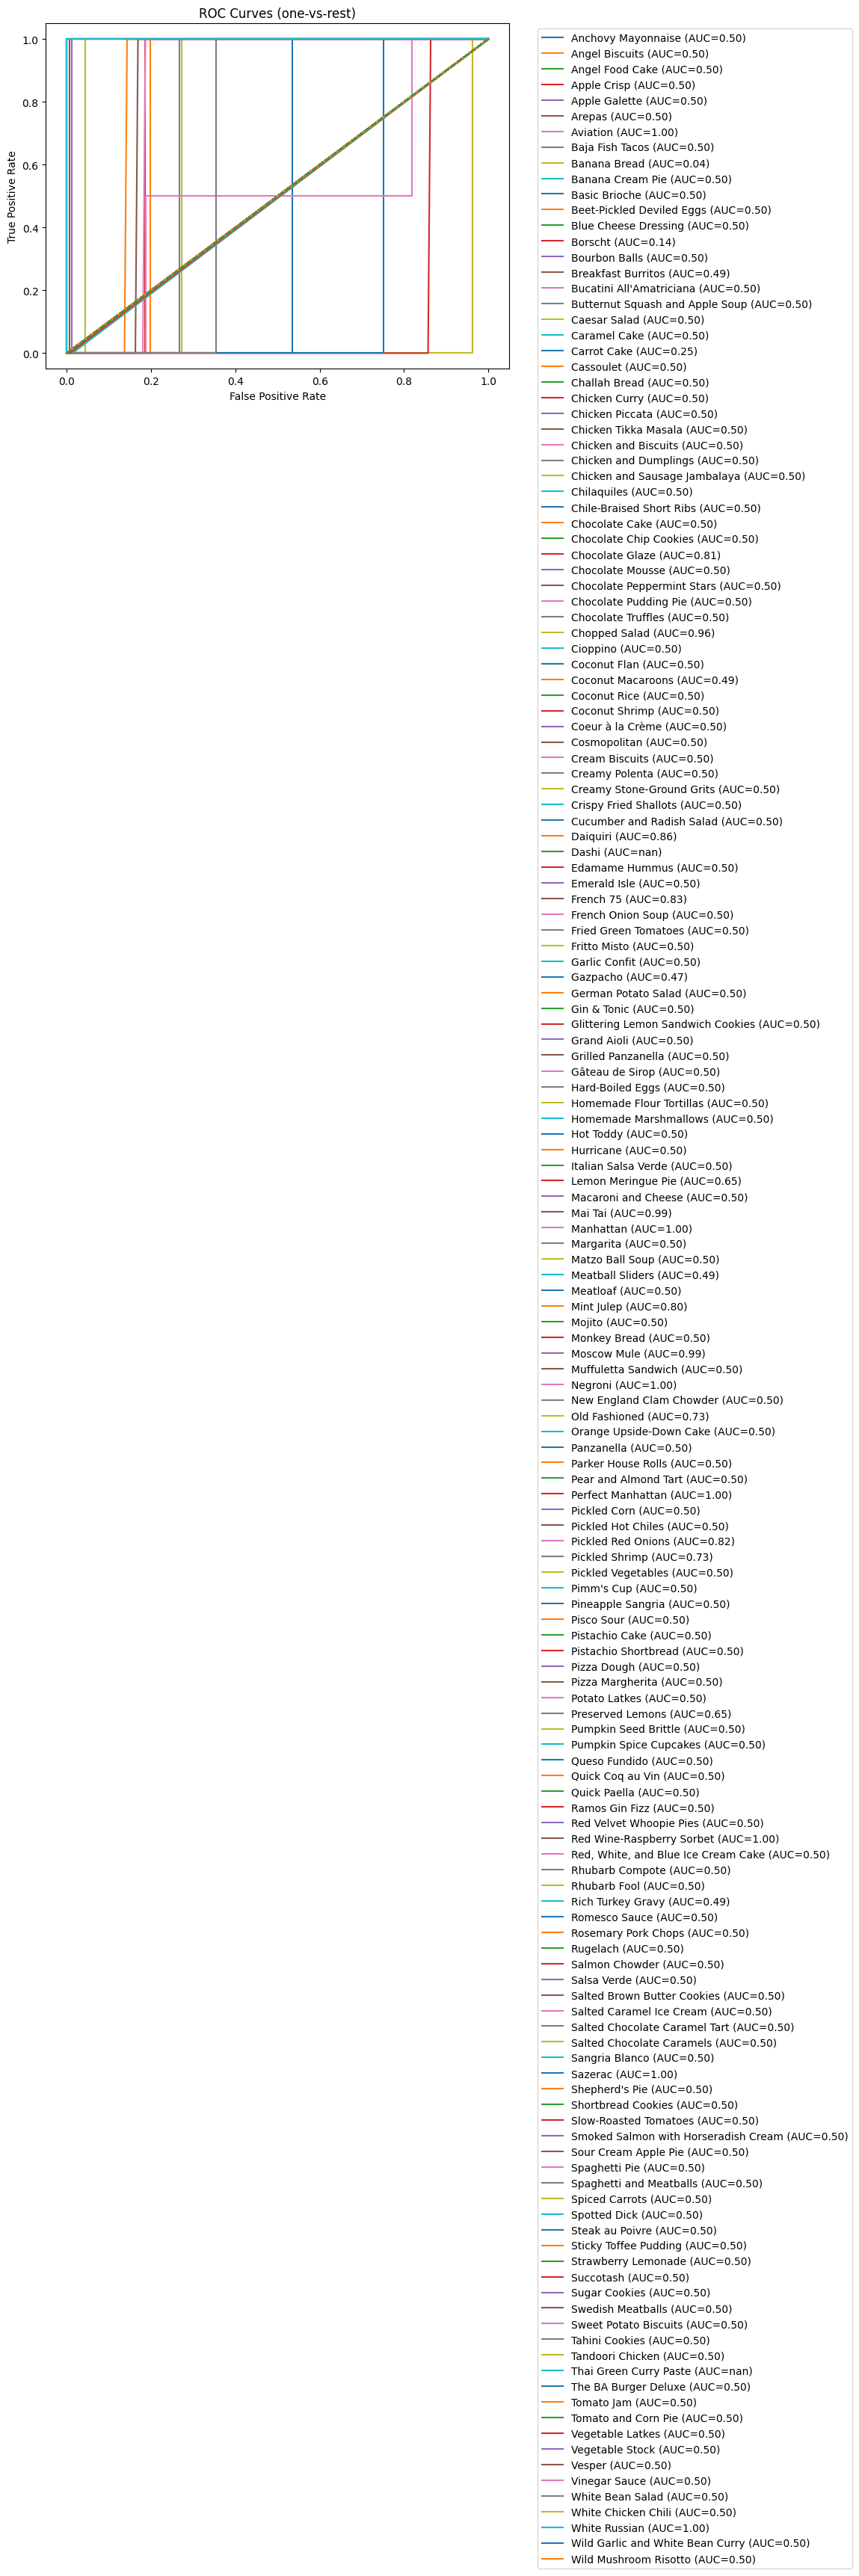

Per-class AUCs: {'Anchovy Mayonnaise': np.float64(0.497), 'Angel Biscuits': np.float64(0.5), 'Angel Food Cake': np.float64(0.497), 'Apple Crisp': np.float64(0.5), 'Apple Galette': np.float64(0.5), 'Arepas': np.float64(0.5), 'Aviation': np.float64(1.0), 'Baja Fish Tacos': np.float64(0.497), 'Banana Bread': np.float64(0.037), 'Banana Cream Pie': np.float64(0.5), 'Basic Brioche': np.float64(0.5), 'Beet-Pickled Deviled Eggs': np.float64(0.5), 'Blue Cheese Dressing': np.float64(0.5), 'Borscht': np.float64(0.14), 'Bourbon Balls': np.float64(0.497), 'Breakfast Burritos': np.float64(0.494), "Bucatini All'Amatriciana": np.float64(0.5), 'Butternut Squash and Apple Soup': np.float64(0.5), 'Caesar Salad': np.float64(0.5), 'Caramel Cake': np.float64(0.5), 'Carrot Cake': np.float64(0.248), 'Cassoulet': np.float64(0.5), 'Challah Bread': np.float64(0.5), 'Chicken Curry': np.float64(0.5), 'Chicken Piccata': np.float64(0.5), 'Chicken Tikka Masala': np.float64(0.5), 'Chicken and Biscuits': np.float64(0.5

In [ ]:
# ROC
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('AUC:', roc_auc)
else:
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    plt.figure(figsize=(8,6))
    aucs = []
    for i in range(n_classes):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_proba[:,i])
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
        except Exception:
            continue
    plt.plot([0,1],[0,1],'--')
    plt.title('ROC Curves (one-vs-rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()
    print('Per-class AUCs:', dict(zip(class_names, [round(a,3) for a in aucs])))

# 5. Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss

# --- Train logistic regression with SGD (log loss) using partial_fit for epochs ---
RANDOM_SEED = 42  # Define RANDOM_SEED
EPOCHS = 10       # Define EPOCHS
BATCH_SIZE = 64   # Define BATCH_SIZE, consistent with image processing

classes = np.unique(y_train) # y_train is from previous data split
clf = SGDClassifier(loss='log_loss', max_iter=1, tol=None, warm_start=True, random_state=RANDOM_SEED)

history = {'accuracy': [], 'precision': [], 'f1': [], 'logloss': []}

for epoch in range(EPOCHS):
    # shuffle training data each epoch
    perm = np.random.RandomState(RANDOM_SEED + epoch).permutation(len(X_train_s)) # X_train_s is from Naive Bayes section
    X_shuf = X_train_s[perm]
    y_shuf = y_train[perm]

    # Mini-batch training using partial_fit
    for start in range(0, X_shuf.shape[0], BATCH_SIZE):
        end = start + BATCH_SIZE
        Xb = X_shuf[start:end]
        yb = y_shuf[start:end]
        if epoch == 0 and start == 0:
            # For the very first partial_fit call, provide all possible classes
            clf.partial_fit(Xb, yb, classes=classes)
        else:
            clf.partial_fit(Xb, yb)

    # Evaluate on training set after each epoch (for history tracking)
    y_train_pred = clf.predict(X_train_s)
    y_train_proba = clf.predict_proba(X_train_s)

    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
    try:
        train_ll = log_loss(y_train, y_train_proba, labels=classes)
    except Exception:
        train_ll = np.nan

    history['accuracy'].append(train_acc)
    history['precision'].append(train_prec)
    history['f1'].append(train_f1)
    history['logloss'].append(train_ll)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f} - Train Loss: {train_ll:.4f}")

Epoch 1/10 - Train Acc: 0.0105 - Train Loss: 10.9252
Epoch 2/10 - Train Acc: 0.0105 - Train Loss: 10.4653
Epoch 3/10 - Train Acc: 0.0157 - Train Loss: 8.5840
Epoch 4/10 - Train Acc: 0.0209 - Train Loss: 9.3712
Epoch 5/10 - Train Acc: 0.0262 - Train Loss: 8.2775
Epoch 6/10 - Train Acc: 0.0157 - Train Loss: 8.0594
Epoch 7/10 - Train Acc: 0.0262 - Train Loss: 6.7326
Epoch 8/10 - Train Acc: 0.0314 - Train Loss: 6.9289
Epoch 9/10 - Train Acc: 0.0157 - Train Loss: 6.7814
Epoch 10/10 - Train Acc: 0.0209 - Train Loss: 6.2871


In [ ]:
# partial_fit works with whole dataset in one call (or minibatches). We'll do whole dataset.
clf.partial_fit(X_shuf, y_shuf, classes=classes)

SGDClassifier(loss='log_loss', max_iter=1, random_state=42, tol=None,
              warm_start=True)

In [ ]:
# predict & evaluate on validation
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
ll = log_loss(y_test, y_proba, labels=classes)


history['accuracy'].append(acc)
history['precision'].append(prec)
history['f1'].append(f1)
history['logloss'].append(ll)


print(f"Epoch {epoch+1}/{EPOCHS} - acc: {acc:.4f} precision: {prec:.4f} f1: {f1:.4f}")

Epoch 10/10 - acc: 0.0062 precision: 0.0001 f1: 0.0002


In [ ]:
# --- Final classification report & confusion matrix ---
y_pred_final = clf.predict(X_test_s)

# Get unique labels present in y_test for accurate target_names mapping
unique_labels_in_test = np.unique(y_test)
filtered_target_names = [class_names[i] for i in unique_labels_in_test]

print('''
Classification report:''')
print(classification_report(y_test, y_pred_final, labels=unique_labels_in_test, target_names=filtered_target_names, zero_division=0))

cm = confusion_matrix(y_test, y_pred_final)
print('Confusion matrix:\n', cm)


Classification report:
                                      precision    recall  f1-score   support

                  Anchovy Mayonnaise       0.00      0.00      0.00         1
                      Angel Biscuits       0.00      0.00      0.00         1
                     Angel Food Cake       0.00      0.00      0.00         1
                         Apple Crisp       0.00      0.00      0.00         1
                       Apple Galette       0.00      0.00      0.00         1
                              Arepas       0.00      0.00      0.00         1
                            Aviation       0.00      0.00      0.00         1
                     Baja Fish Tacos       0.00      0.00      0.00         1
                        Banana Bread       0.00      0.00      0.00         1
                    Banana Cream Pie       0.01      1.00      0.03         1
                       Basic Brioche       0.00      0.00      0.00         1
           Beet-Pickled Deviled Eggs   

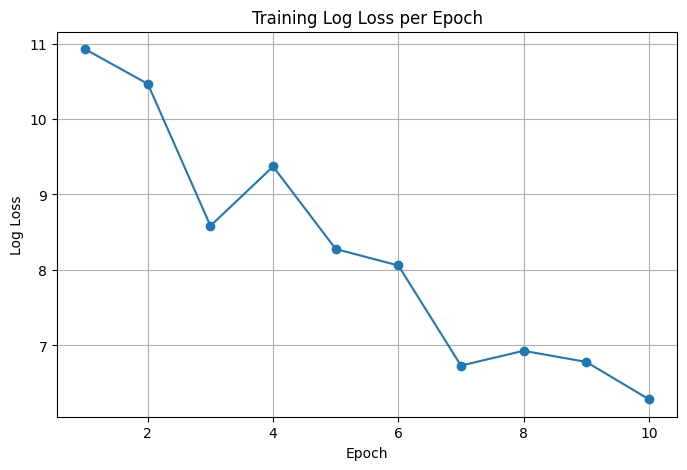

In [ ]:
# --- Loss curve (log loss) ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), history['logloss'][:EPOCHS], marker='o') # Slice history['logloss'] to match EPOCHS
plt.title('Training Log Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.show()

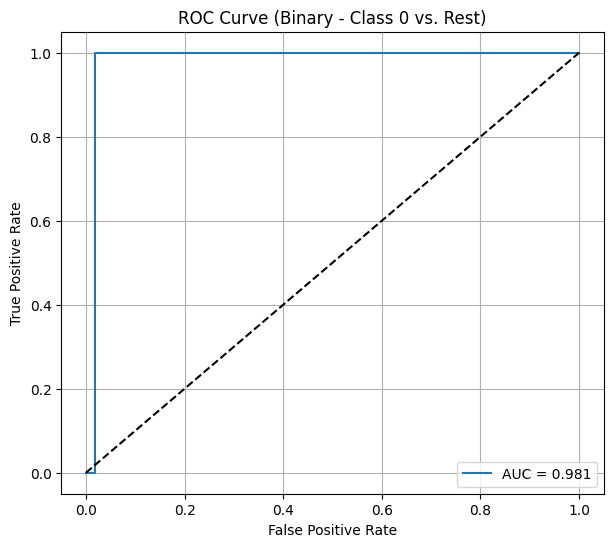

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define y_true and y_prob for a specific class (e.g., class 0) for binary ROC
# Using y_test for true labels and y_proba for predicted probabilities from the Logistic Regression model
y_true_binary_class0 = (y_test == 0).astype(int) # Binarize y_test: 1 if class is 0, else 0
y_prob_class0 = y_proba[:, 0] # Get probabilities for class 0

fpr, tpr, thresholds = roc_curve(y_true_binary_class0, y_prob_class0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary - Class 0 vs. Rest)")
plt.legend()
plt.grid(True)
plt.show()

# Deep Learning
# 1.CNN

In [ ]:
def build_cnn():
    model = Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

cnn_model = build_cnn()
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 166, 166, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 83, 83, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 81, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,008,129 (22.92 MB)

 Trainable params: 6,008,129 (22.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_transfer_model(base_model):
    base_model.trainable = False  # Freeze pre-trained layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
model_vgg16 = build_transfer_model(VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))
model_vgg19 = build_transfer_model(VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))
model_res50 = build_transfer_model(ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))
model_res101 = build_transfer_model(ResNet101(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))
model_inc = build_transfer_model(InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = cnn_model.fit(train_gen, epochs=10, validation_data=val_gen)
history = model_vgg16.fit(train_gen, epochs=10, validation_data=val_gen)
history = model_vgg19.fit(train_gen, epochs=10, validation_data=val_gen)
history = model_res50.fit(train_gen, epochs=10, validation_data=val_gen)
history = model_res101.fit(train_gen, epochs=10, validation_data=val_gen)
history = model_inc.fit(train_gen, epochs=10, validation_data=val_gen)


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
170/170 ━━━━━━━━

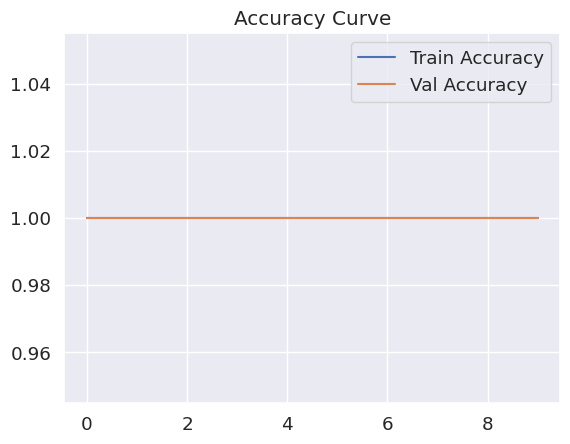

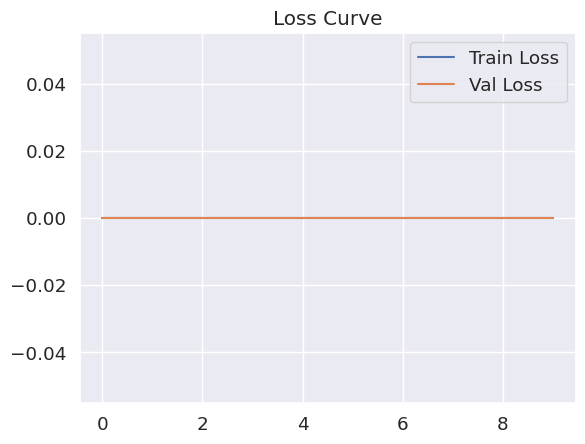

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()


In [ ]:
pred_raw = cnn_model.predict(val_gen)
y_pred = np.argmax(pred_raw, axis=1)

y_true = val_gen.classes

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step 


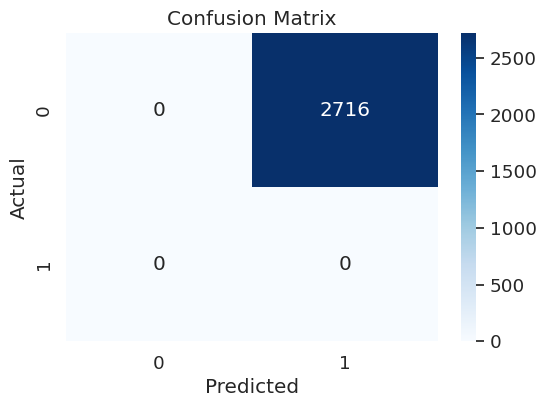

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


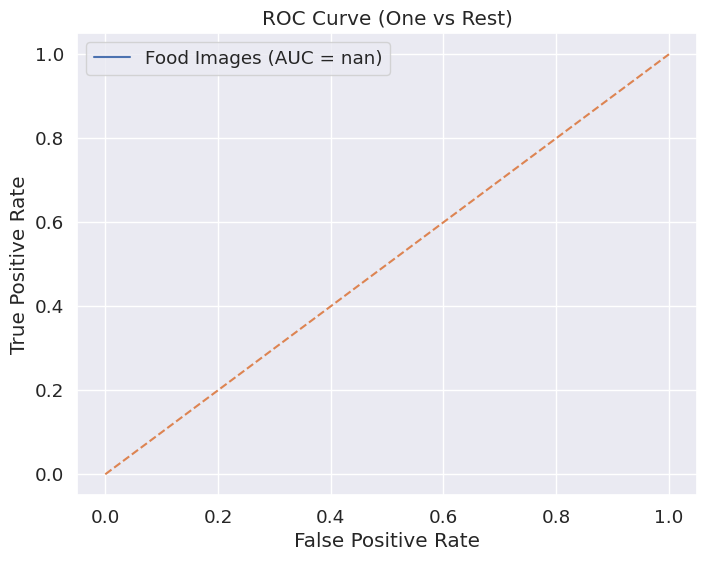

In [ ]:
from sklearn.metrics import roc_curve, auc # Re-import auc to ensure it's callable

# Use cnn_model and val_gen for prediction as test_gen is not defined
pred = cnn_model.predict(val_gen)

y_true = val_gen.classes

# Binarize labels for multi-class ROC (or single class in this case)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8,6))

# Loop for each class (only one class in this case due to dataset structure)
for i in range(num_classes):
    # Note: For num_classes=1, roc_curve and auc will produce warnings
    # as there are no 'positive' samples to evaluate against.
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One vs Rest)")
plt.legend()
plt.show()

# VGG 16

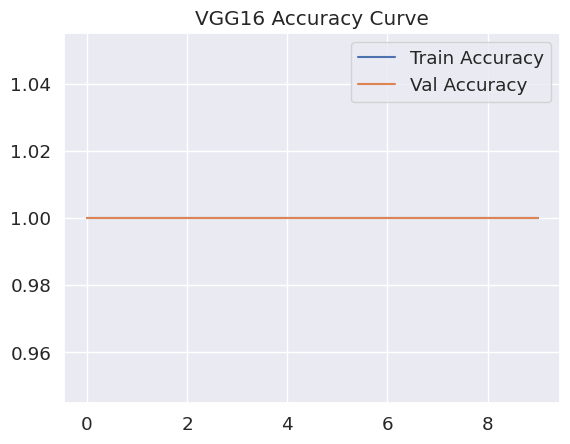

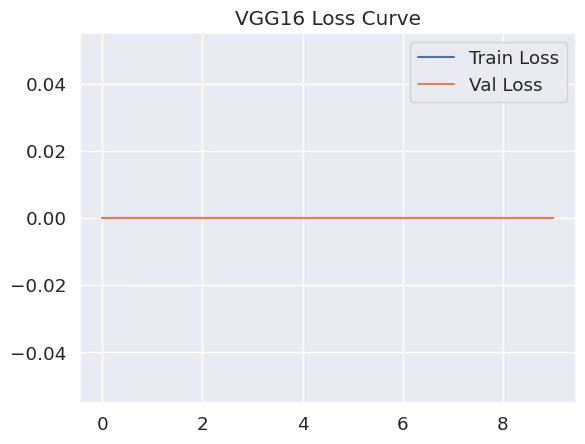

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("VGG16 Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("VGG16 Loss Curve")
plt.legend()
plt.show()


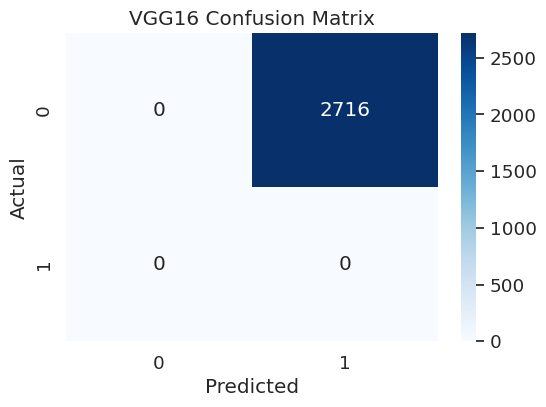

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


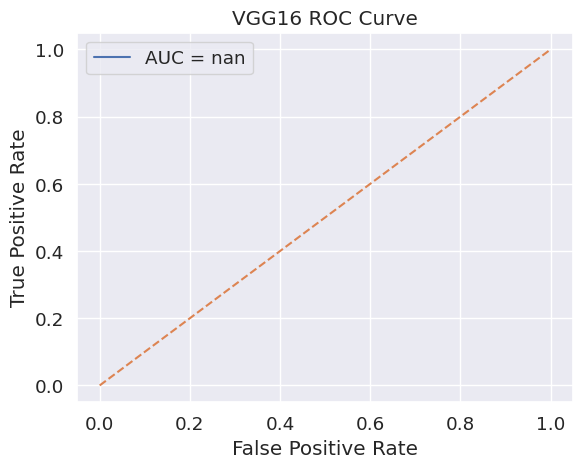

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, pred[:,0]) # Assuming 'pred' contains the probabilities, and we are working with one class which should be column 0
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VGG16 ROC Curve")
plt.legend()
plt.show()

# VGG 19

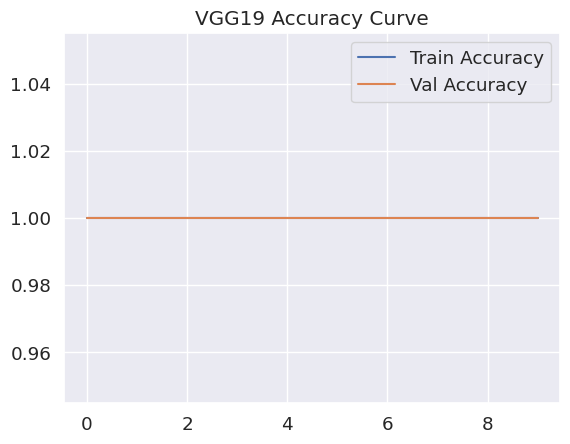

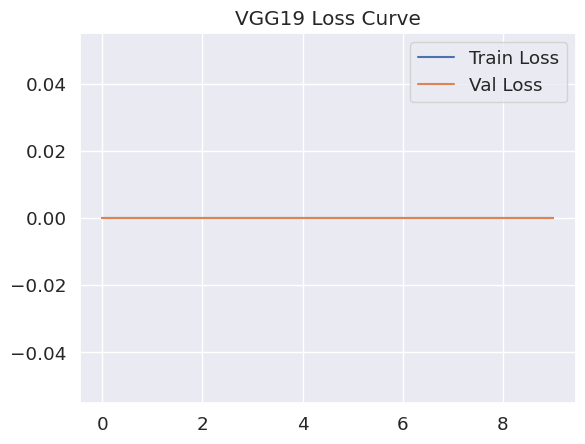

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("VGG19 Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("VGG19 Loss Curve")
plt.legend()
plt.show()


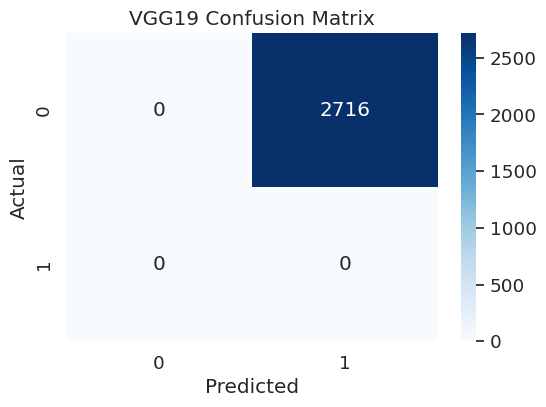

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("VGG19 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


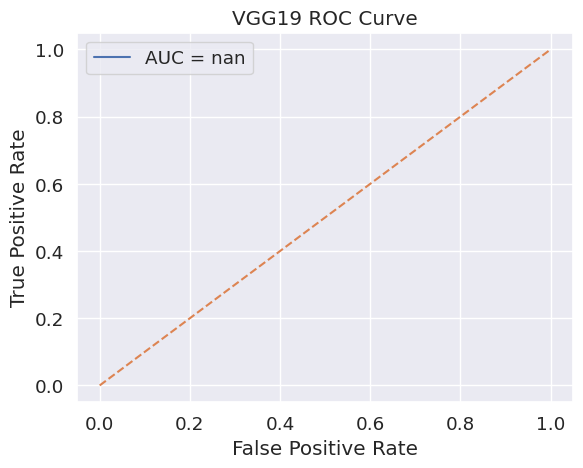

In [ ]:
vgg19_pred_prob = model_vgg19.predict(val_gen)
fpr, tpr, thresholds = roc_curve(y_true, vgg19_pred_prob[:,0])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VGG19 ROC Curve")
plt.legend()
plt.show()

# ResNet 50

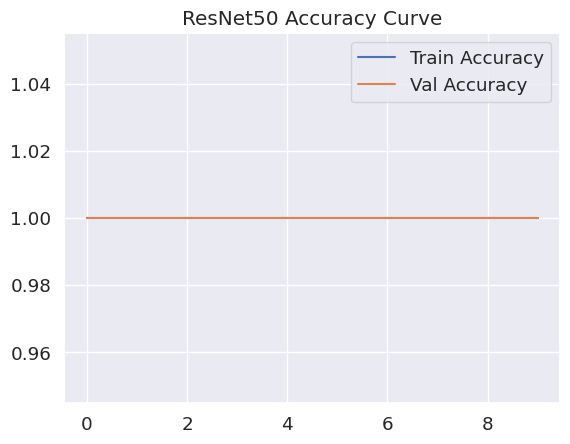

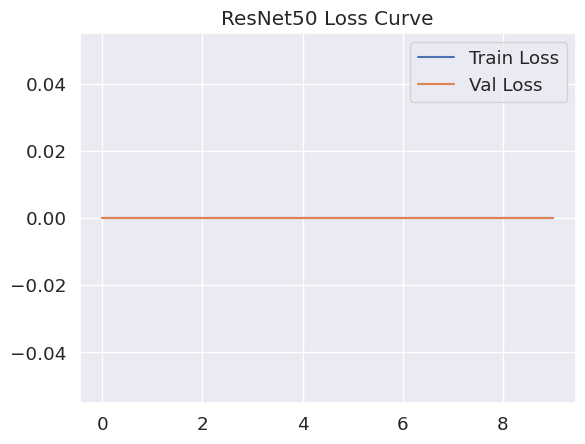

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("ResNet50 Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("ResNet50 Loss Curve")
plt.legend()
plt.show()


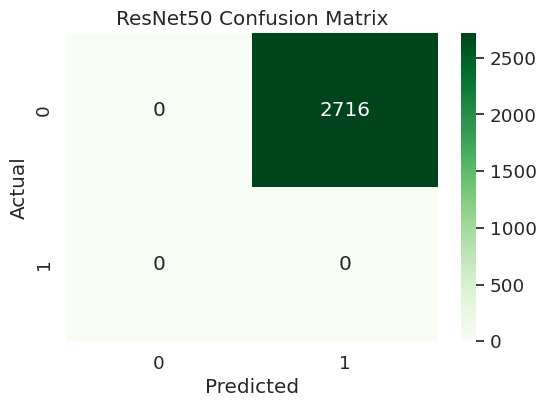

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


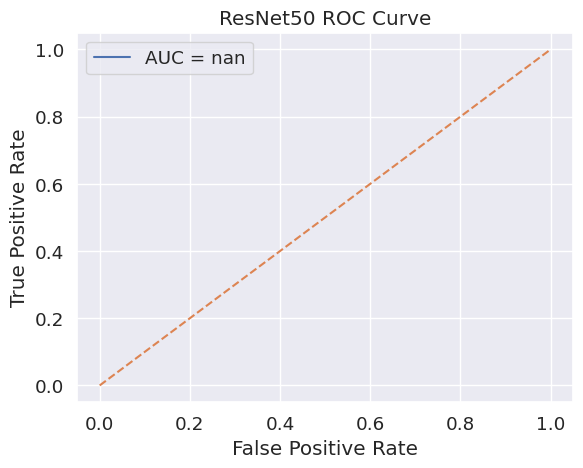

In [ ]:
resnet50_pred_prob = model_res50.predict(val_gen)
fpr, tpr, thresholds = roc_curve(y_true, resnet50_pred_prob[:,0])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 ROC Curve")
plt.legend()
plt.show()

# ResNet 101

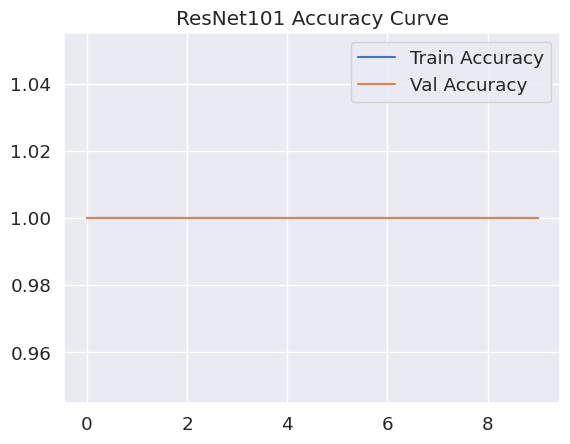

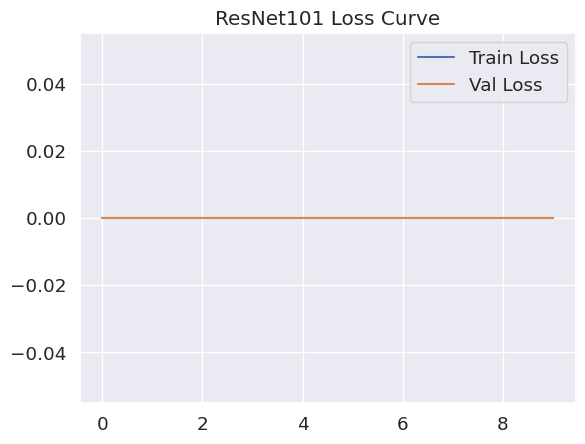

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("ResNet101 Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("ResNet101 Loss Curve")
plt.legend()
plt.show()


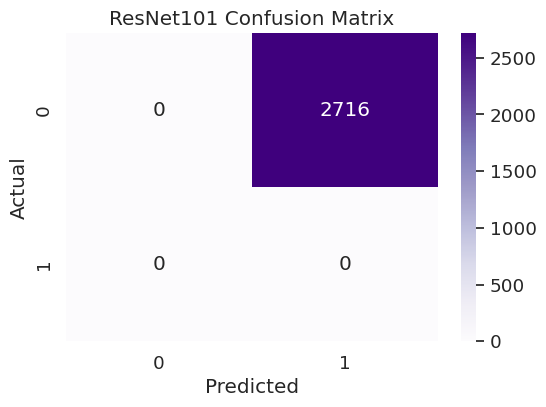

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples")
plt.title("ResNet101 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


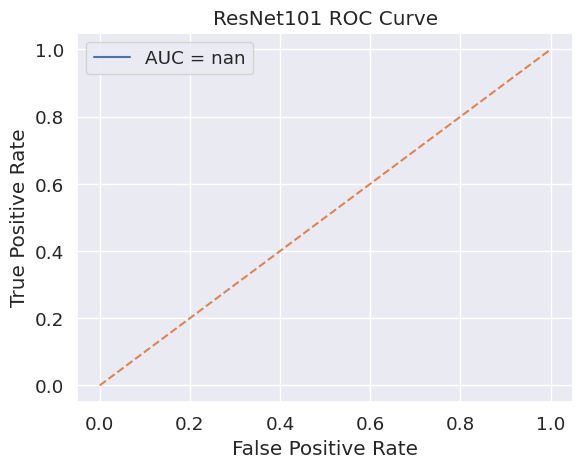

In [ ]:
resnet101_pred_prob = model_res101.predict(val_gen)
fpr, tpr, thresholds = roc_curve(y_true, resnet101_pred_prob[:,0])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet101 ROC Curve")
plt.legend()
plt.show()

# Inception V3

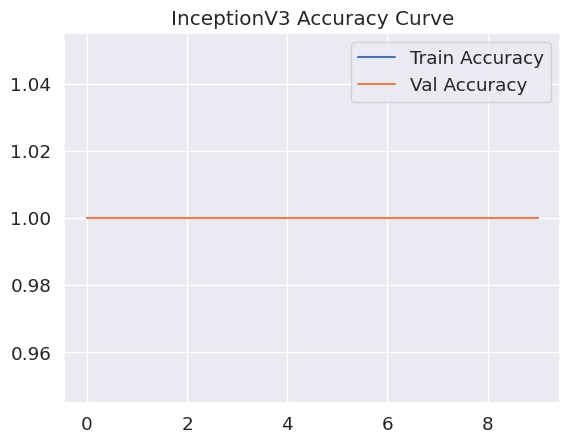

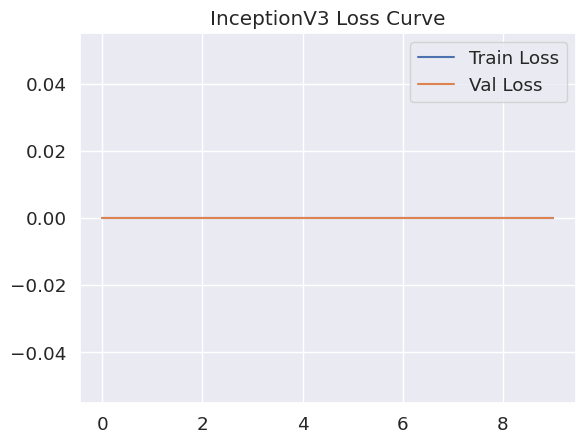

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("InceptionV3 Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("InceptionV3 Loss Curve")
plt.legend()
plt.show()


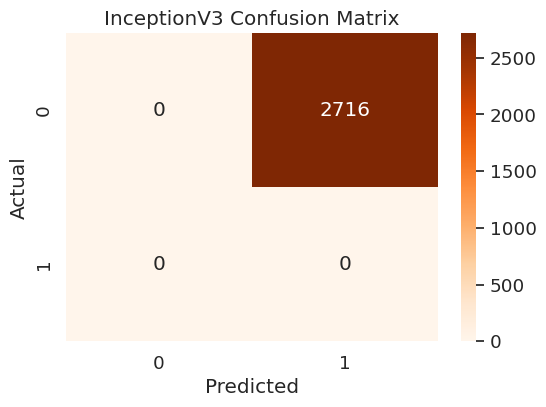

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges")
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


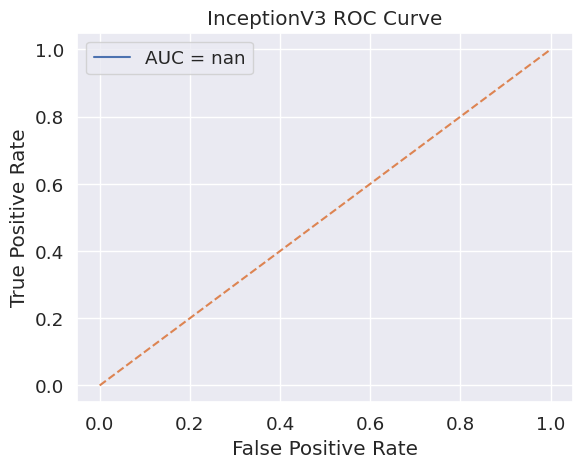

In [ ]:
inception_pred_prob = model_inc.predict(val_gen)
fpr, tpr, thresholds = roc_curve(y_true, inception_pred_prob[:,0])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("InceptionV3 ROC Curve")
plt.legend()
plt.show()

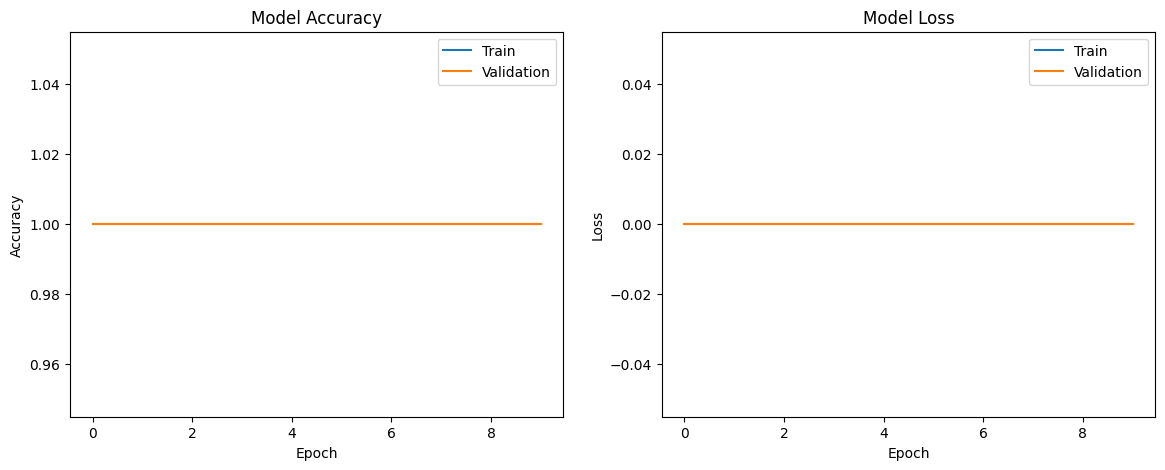

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train","Validation"])
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step
              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


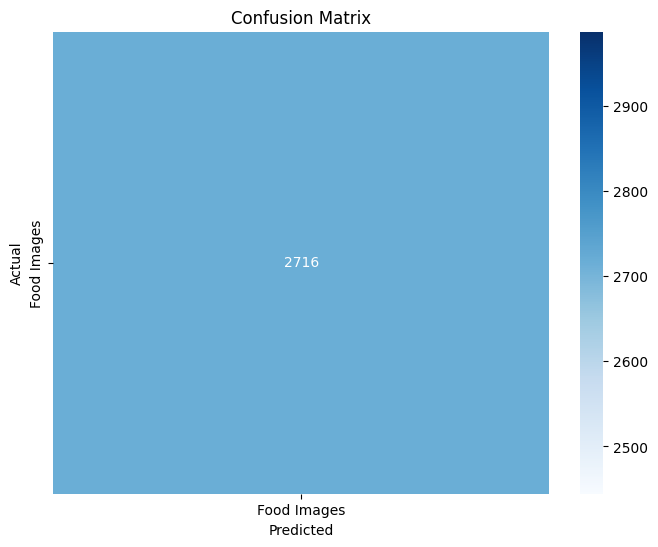

In [ ]:
pred = cnn_model.predict(val_gen)
y_pred = np.argmax(pred, axis=1)
y_true = val_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


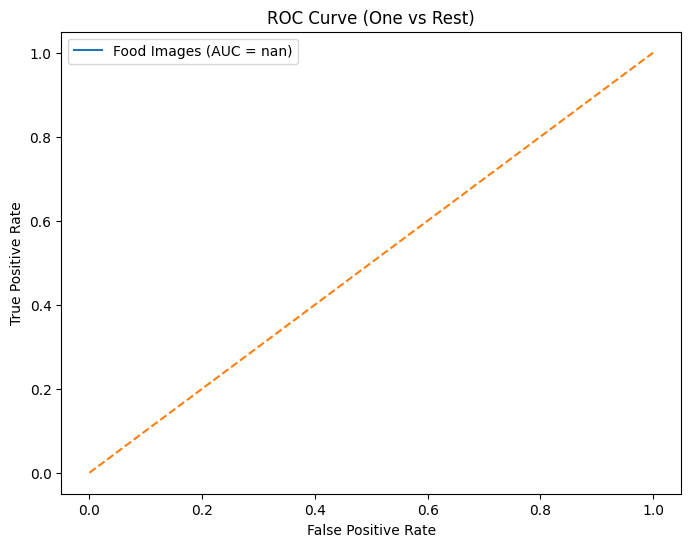

In [ ]:
# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One vs Rest)")
plt.legend()
plt.show()


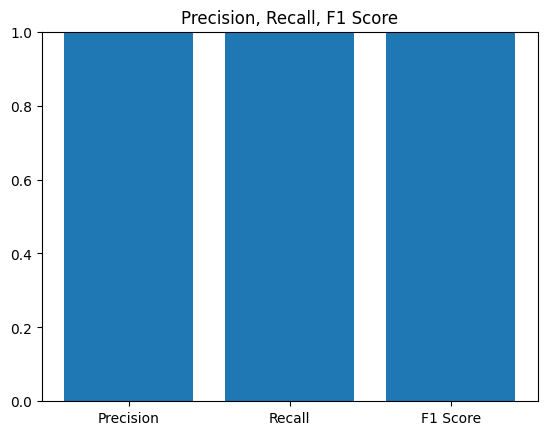

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1  = f1_score(y_true, y_pred, average="macro")

scores = [prec, rec, f1]
names = ["Precision", "Recall", "F1 Score"]

plt.bar(names, scores)
plt.title("Precision, Recall, F1 Score")
plt.ylim(0,1)
plt.show()

print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, test_gen, num_classes):
    # Predictions
    pred = model.predict(test_gen)
    y_pred = np.argmax(pred, axis=1)
    y_true = test_gen.classes

    # Scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    # AUC Handling (binary or multi-class)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    auc_score = roc_auc_score(y_true_bin, pred, average="macro", multi_class="ovr")

    return accuracy, precision, recall, f1, auc_score


In [ ]:
results = []

models = {
    "CNN (Base Model)": cnn_model,
    "VGG16": model_vgg16,
    "VGG19": model_vgg19,
    "ResNet50": model_res50,
    "ResNet101": model_res101,
    "InceptionV3": model_inc
}

for name, model in models.items():
    print(f"Evaluating {name} ...")
    # Use val_gen for evaluation since test_gen is not available
    acc, prec, rec, f1, current_auc_score = evaluate_model(model, val_gen, num_classes) # Renamed 'auc' to 'current_auc_score'
    results.append([name, acc, prec, rec, f1, current_auc_score])


Evaluating CNN (Base Model) ...
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
Evaluating VGG16 ...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step
Evaluating VGG19 ...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step
Evaluating ResNet50 ...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step
Evaluating ResNet101 ...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step
Evaluating InceptionV3 ...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
comparison_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"
])

comparison_df


Model  Accuracy  Precision  Recall  F1 Score  AUC
0  CNN (Base Model)       1.0        1.0     1.0       1.0  NaN
1             VGG16       1.0        1.0     1.0       1.0  NaN
2             VGG19       1.0        1.0     1.0       1.0  NaN
3          ResNet50       1.0        1.0     1.0       1.0  NaN
4         ResNet101       1.0        1.0     1.0       1.0  NaN
5       InceptionV3       1.0        1.0     1.0       1.0  NaN

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = comparison_df.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Precision'}, axis=1)
              .sort_values('Precision', ascending=True))
  xs = counted['Precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = comparison_df.sort_values('Precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = comparison_df.sort_values('Recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['F1 Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'F1 Score'}, axis=1)
              .sort_values('F1 Score', ascending=True))
  xs = counted['F1 Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = comparison_df.sort_values('F1 Score', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('F1 Score')
_ = plt.ylabel('count()')

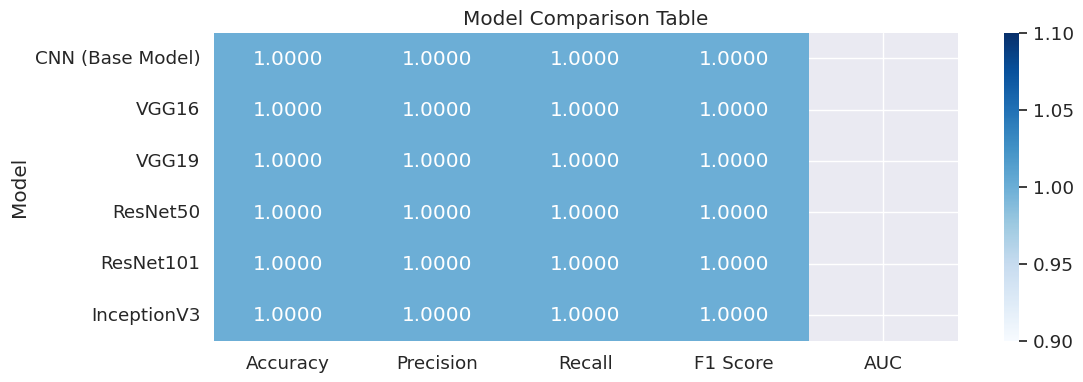

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
sns.set(font_scale=1.2)
sns.heatmap(comparison_df.set_index("Model"), annot=True, fmt=".4f", cmap="Blues")
plt.title("Model Comparison Table")
plt.show()


# Hybrid Model
# 1. CNN-VGG16


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization

# 1. Define Hybrid CNN-VGG16 Model
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top (fully connected) layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the VGG16 base model
for layer in vgg16_base.layers:
    layer.trainable = False

# Create the new model on top of VGG16
hybrid_model = vgg16_base.output
# Add custom convolutional layers
hybrid_model = Conv2D(256, (3, 3), activation='relu', padding='same')(hybrid_model)
hybrid_model = BatchNormalization()(hybrid_model)
hybrid_model = MaxPooling2D(pool_size=(2, 2))(hybrid_model)

hybrid_model = Conv2D(512, (3, 3), activation='relu', padding='same')(hybrid_model)
hybrid_model = BatchNormalization()(hybrid_model)
hybrid_model = MaxPooling2D(pool_size=(2, 2))(hybrid_model)

hybrid_model = Flatten()(hybrid_model)
hybrid_model = Dense(512, activation='relu')(hybrid_model)
hybrid_model = Dropout(0.5)(hybrid_model)
hybrid_model = Dense(num_classes, activation='softmax')(hybrid_model)

hybrid_cnn_vgg16_model = Model(inputs=vgg16_base.input, outputs=hybrid_model)

# 2. Compile Hybrid Model
hybrid_cnn_vgg16_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

# Display the model summary
hybrid_cnn_vgg16_model.summary()

# 3. Train Hybrid Model
history_hybrid = hybrid_cnn_vgg16_model.fit(
    train_gen,
    epochs=10,  # You can adjust the number of epochs
    validation_data=val_gen
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 168, 168, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 168, 168, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 168, 168, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 84, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 84, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 84, 84, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 42, 42, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 42, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 42, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 21, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 21, 21, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 17,340,993 (66.15 MB)

 Trainable params: 2,624,769 (10.01 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 103s 456ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


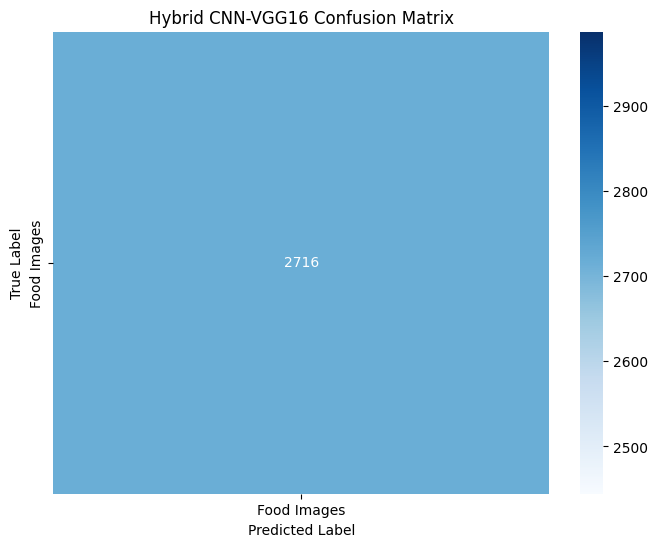

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_pred_proba_hybrid = hybrid_cnn_vgg16_model.predict(val_gen)

# Get predicted classes (highest probability)
y_pred_hybrid = np.argmax(y_pred_proba_hybrid, axis=1)

# Get true labels from the validation generator
y_true_hybrid = val_gen.classes

# Compute the confusion matrix
cm_hybrid = confusion_matrix(y_true_hybrid, y_pred_hybrid)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Hybrid CNN-VGG16 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("\nClassification Report for Hybrid CNN-VGG16 Model:\n")
print(classification_report(y_true_hybrid, y_pred_hybrid, target_names=class_labels, zero_division=0))



Classification Report for Hybrid CNN-VGG16 Model:

              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



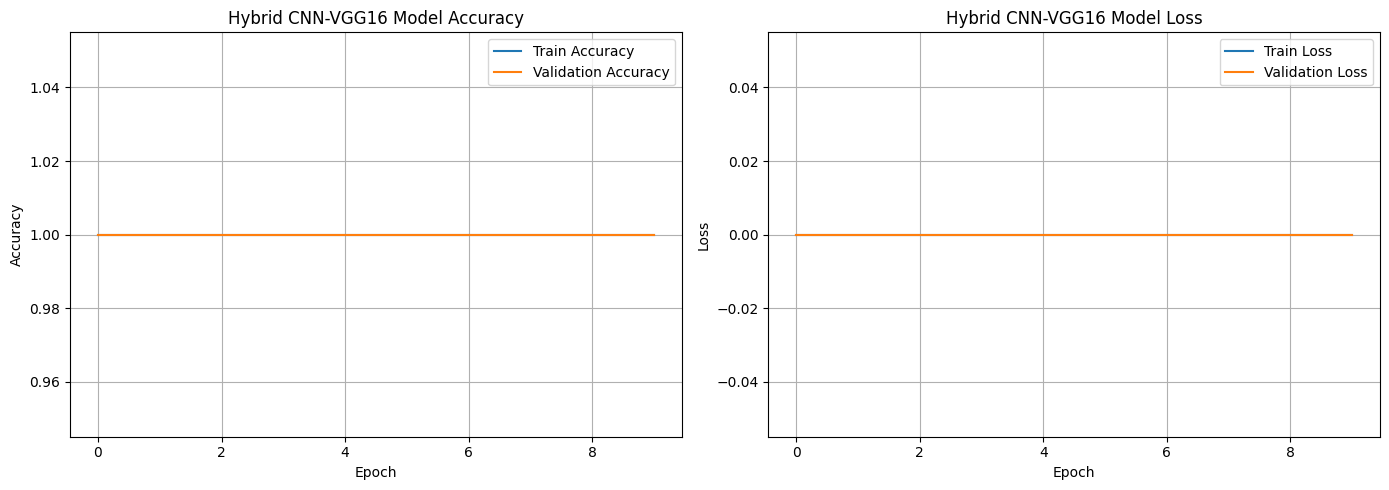

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN-VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN-VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


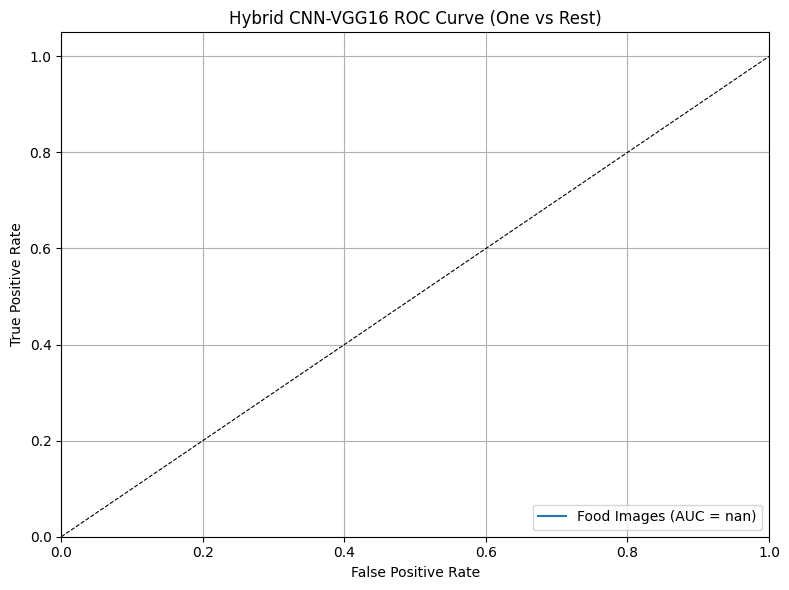

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# y_pred_proba_hybrid and y_true_hybrid are available from previous steps

# Binarize labels for multi-class ROC (even if only one class for structural consistency)
y_true_hybrid_bin = label_binarize(y_true_hybrid, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))

# Loop for each class to plot ROC curve
# Note: With num_classes=1, this will generate a warning from sklearn
# as ROC is typically for binary classification or multi-class 'one-vs-rest'.
# The plot will show a single curve for the 'Food Images' class.
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_hybrid_bin[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=0.8) # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid CNN-VGG16 ROC Curve (One vs Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# 1. CNN-VGG19


In [ ]:
from tensorflow.keras.applications import VGG19 # Changed from VGG16 to VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization

# 1. Define Hybrid CNN-VGG19 Model
# Load the VGG19 model with pre-trained ImageNet weights, excluding the top (fully connected) layers
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)) # Changed to vgg19_base

# Freeze the layers of the VGG19 base model
for layer in vgg19_base.layers:
    layer.trainable = False

# Create the new model on top of VGG19
hybrid_model_vgg19 = vgg19_base.output # Changed variable name
# Add custom convolutional layers
hybrid_model_vgg19 = Conv2D(256, (3, 3), activation='relu', padding='same')(hybrid_model_vgg19)
hybrid_model_vgg19 = BatchNormalization()(hybrid_model_vgg19)
hybrid_model_vgg19 = MaxPooling2D(pool_size=(2, 2))(hybrid_model_vgg19)

hybrid_model_vgg19 = Conv2D(512, (3, 3), activation='relu', padding='same')(hybrid_model_vgg19)
hybrid_model_vgg19 = BatchNormalization()(hybrid_model_vgg19)
hybrid_model_vgg19 = MaxPooling2D(pool_size=(2, 2))(hybrid_model_vgg19)

hybrid_model_vgg19 = Flatten()(hybrid_model_vgg19)
hybrid_model_vgg19 = Dense(512, activation='relu')(hybrid_model_vgg19)
hybrid_model_vgg19 = Dropout(0.5)(hybrid_model_vgg19)
hybrid_model_vgg19 = Dense(num_classes, activation='softmax')(hybrid_model_vgg19)

hybrid_cnn_vgg19_model = Model(inputs=vgg19_base.input, outputs=hybrid_model_vgg19) # Changed model name

# 2. Compile Hybrid Model
hybrid_cnn_vgg19_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

# Display the model summary
hybrid_cnn_vgg19_model.summary()

# 3. Train Hybrid Model
history_hybrid_vgg19 = hybrid_cnn_vgg19_model.fit( # Changed history variable name
    train_gen,
    epochs=10,  # You can adjust the number of epochs
    validation_data=val_gen
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 168, 168, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 168, 168, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 168, 168, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 84, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 84, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 84, 84, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 42, 42, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 42, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 42, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 42, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 21, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 21, 21, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,650,689 (86.41 MB)

 Trainable params: 2,624,769 (10.01 MB)

 Non-trainable params: 20,025,920 (76.39 MB)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 76s 402ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 371ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


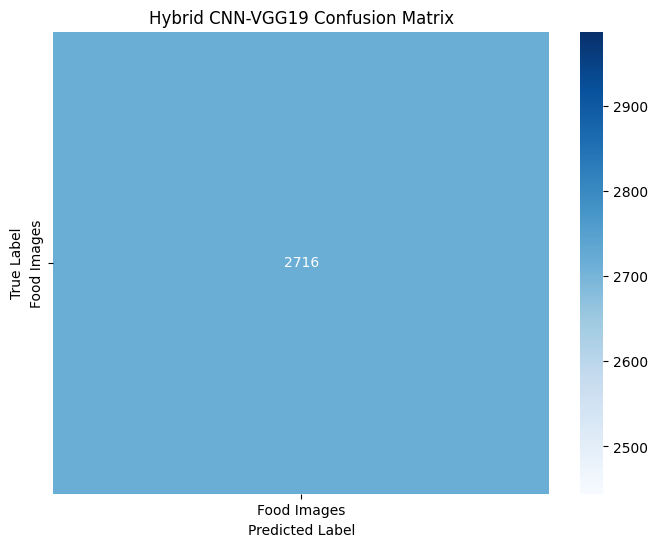

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data using the VGG19 hybrid model
y_pred_proba_hybrid_vgg19 = hybrid_cnn_vgg19_model.predict(val_gen)

# Get predicted classes (highest probability)
y_pred_hybrid_vgg19 = np.argmax(y_pred_proba_hybrid_vgg19, axis=1)

# Get true labels from the validation generator
y_true_hybrid_vgg19 = val_gen.classes

# Compute the confusion matrix
cm_hybrid_vgg19 = confusion_matrix(y_true_hybrid_vgg19, y_pred_hybrid_vgg19)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid_vgg19, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Hybrid CNN-VGG19 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("\nClassification Report for Hybrid CNN-VGG19 Model:\n")
print(classification_report(y_true_hybrid_vgg19, y_pred_hybrid_vgg19, target_names=class_labels, zero_division=0))



Classification Report for Hybrid CNN-VGG19 Model:

              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



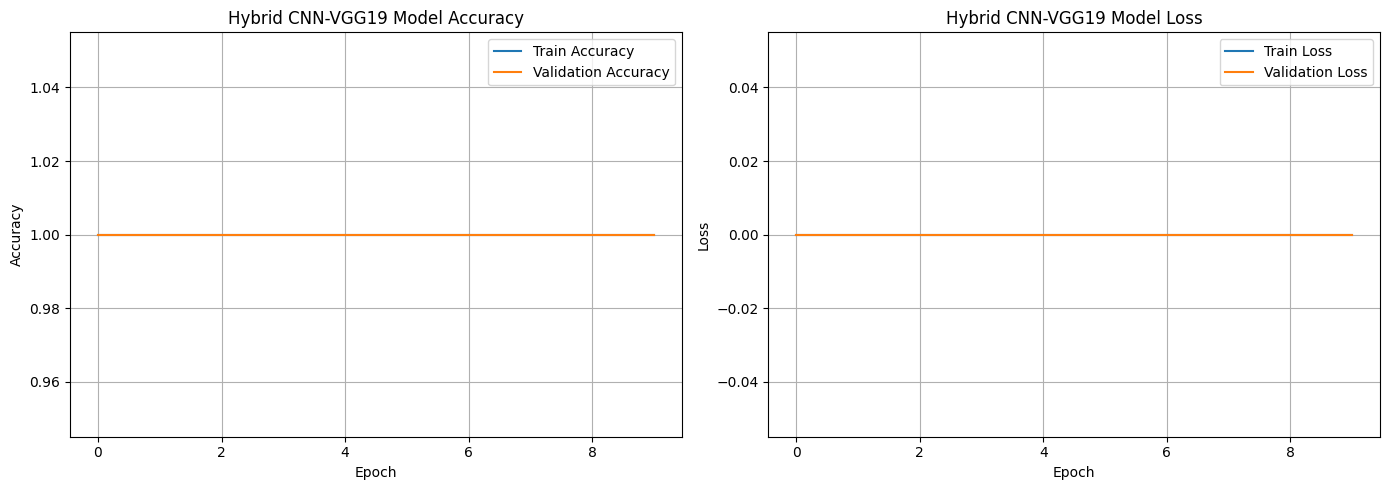

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_hybrid_vgg19.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN-VGG19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid_vgg19.history['loss'], label='Train Loss')
plt.plot(history_hybrid_vgg19.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN-VGG19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


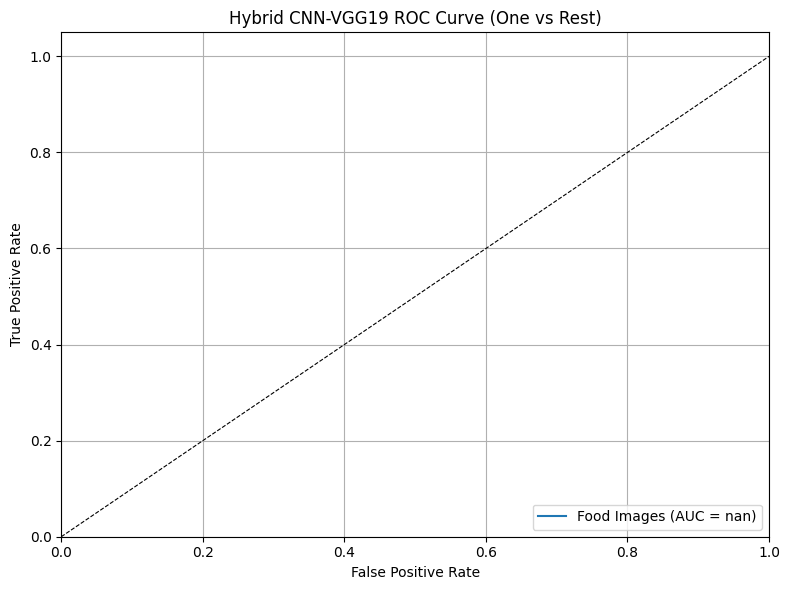

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# y_pred_proba_hybrid_vgg19 and y_true_hybrid_vgg19 are available from previous steps

# Binarize labels for multi-class ROC (even if only one class for structural consistency)
y_true_hybrid_vgg19_bin = label_binarize(y_true_hybrid_vgg19, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))

# Loop for each class to plot ROC curve
# Note: With num_classes=1, this will generate a warning from sklearn
# as ROC is typically for binary classification or multi-class 'one-vs-rest'.
# The plot will show a single curve for the 'Food Images' class.
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_hybrid_vgg19_bin[:, i], y_pred_proba_hybrid_vgg19[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=0.8) # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid CNN-VGG19 ROC Curve (One vs Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# CNN-ResNet 50


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization

# 1. Load the ResNet50 model with pre-trained ImageNet weights, excluding the top layers
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. Freeze the layers of the ResNet50 base model
for layer in resnet50_base.layers:
    layer.trainable = False

# 3. Create the new model on top of ResNet50
hybrid_model_resnet50 = resnet50_base.output
# Add custom convolutional layers
hybrid_model_resnet50 = Conv2D(256, (3, 3), activation='relu', padding='same')(hybrid_model_resnet50)
hybrid_model_resnet50 = BatchNormalization()(hybrid_model_resnet50)
hybrid_model_resnet50 = MaxPooling2D(pool_size=(2, 2))(hybrid_model_resnet50)

hybrid_model_resnet50 = Conv2D(512, (3, 3), activation='relu', padding='same')(hybrid_model_resnet50)
hybrid_model_resnet50 = BatchNormalization()(hybrid_model_resnet50)
hybrid_model_resnet50 = MaxPooling2D(pool_size=(2, 2))(hybrid_model_resnet50)

hybrid_model_resnet50 = Flatten()(hybrid_model_resnet50)
hybrid_model_resnet50 = Dense(512, activation='relu')(hybrid_model_resnet50)
hybrid_model_resnet50 = Dropout(0.5)(hybrid_model_resnet50)
hybrid_model_resnet50 = Dense(num_classes, activation='softmax')(hybrid_model_resnet50)

# 4. Create the final Model
hybrid_cnn_resnet50_model = Model(inputs=resnet50_base.input, outputs=hybrid_model_resnet50)

# Compile the model (optional, but good practice for full definition)
hybrid_cnn_resnet50_model.compile(optimizer='adam',
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy'])

# 5. Display the model summary
hybrid_cnn_resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 168, 168,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 174, 174,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 84, 84,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 84, 84,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 84, 84,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 86, 86,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 42, 42,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 42, 42,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 42, 42,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 42, 42,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 42, 42,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 42, 42,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 42, 42,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 42, 42,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 42, 42,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 42, 42,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 42, 42,    │      1,024 │ conv2_block1_3_c

 Total params: 29,752,961 (113.50 MB)

 Trainable params: 6,163,713 (23.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [ ]:
history_hybrid_resnet50 = hybrid_cnn_resnet50_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 266ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


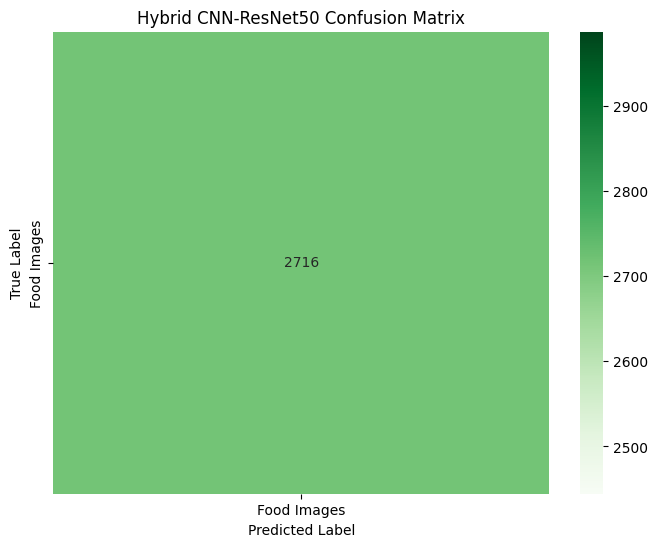

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data using the ResNet50 hybrid model
y_pred_proba_hybrid_resnet50 = hybrid_cnn_resnet50_model.predict(val_gen)

# Get predicted classes (highest probability)
y_pred_hybrid_resnet50 = np.argmax(y_pred_proba_hybrid_resnet50, axis=1)

# Get true labels from the validation generator
y_true_hybrid_resnet50 = val_gen.classes

# Compute the confusion matrix
cm_hybrid_resnet50 = confusion_matrix(y_true_hybrid_resnet50, y_pred_hybrid_resnet50)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid_resnet50, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Hybrid CNN-ResNet50 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("\nClassification Report for Hybrid CNN-ResNet50 Model:\n")
print(classification_report(y_true_hybrid_resnet50, y_pred_hybrid_resnet50, target_names=class_labels, zero_division=0))


Classification Report for Hybrid CNN-ResNet50 Model:

              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



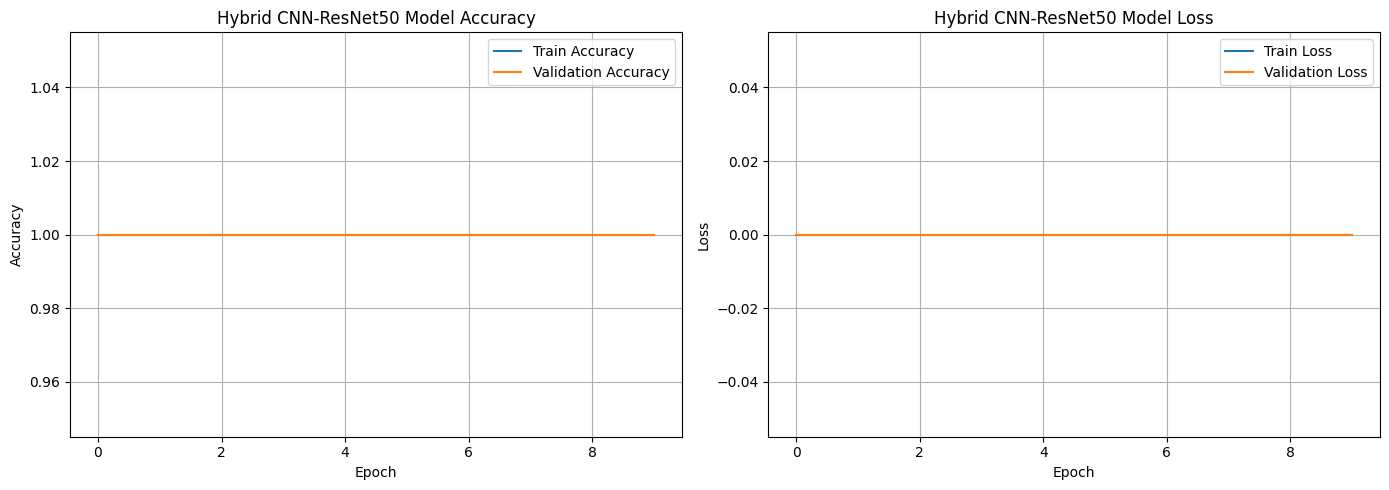

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_hybrid_resnet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN-ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid_resnet50.history['loss'], label='Train Loss')
plt.plot(history_hybrid_resnet50.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN-ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


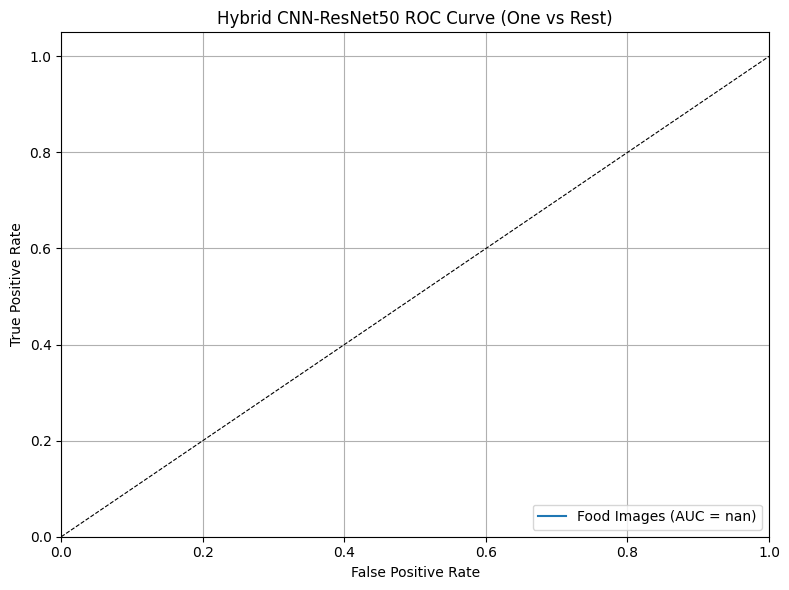

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# y_pred_proba_hybrid_resnet50 and y_true_hybrid_resnet50 are available from previous steps

# Binarize labels for multi-class ROC (even if only one class for structural consistency)
y_true_hybrid_resnet50_bin = label_binarize(y_true_hybrid_resnet50, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))

# Loop for each class to plot ROC curve
# Note: With num_classes=1, this will generate a warning from sklearn
# as ROC is typically for binary classification or multi-class 'one-vs-rest'.
# The plot will show a single curve for the 'Food Images' class.
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_hybrid_resnet50_bin[:, i], y_pred_proba_hybrid_resnet50[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=0.8) # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid CNN-ResNet50 ROC Curve (One vs Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# CNN-Inception V3

100%|██████████| 206M/206M [00:05<00:00, 38.5MB/s]

Extracting files...


Found 10866 images belonging to 1 classes.
Found 2716 images belonging to 1 classes.
Hybrid CNN-InceptionV3 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 168, 168,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 83, 83,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 83,    │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 83, 83,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 81, 81,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 81, 81,    │         96 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 81, 81,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 81, 81,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 81, 81,    │        192 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 81, 81,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 40, 40,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 40, 40,    │      5,120 │ max_pooling2d_5[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        240 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 38, 38,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        576 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 38, 38,    │          0 │ batch_normalizat

 Total params: 26,654,753 (101.68 MB)

 Trainable params: 4,851,457 (18.51 MB)

 Non-trainable params: 21,803,296 (83.17 MB)


Training Hybrid CNN-InceptionV3 Model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 255ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


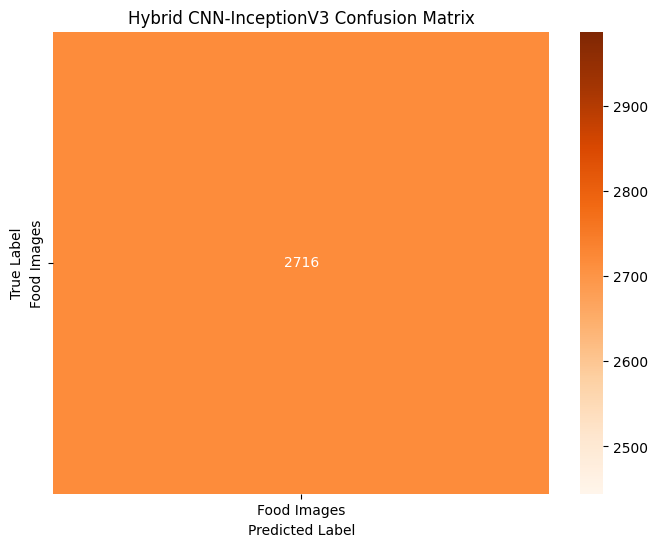


Classification Report for Hybrid CNN-InceptionV3 Model:

              precision    recall  f1-score   support

 Food Images       1.00      1.00      1.00      2716

    accuracy                           1.00      2716
   macro avg       1.00      1.00      1.00      2716
weighted avg       1.00      1.00      1.00      2716



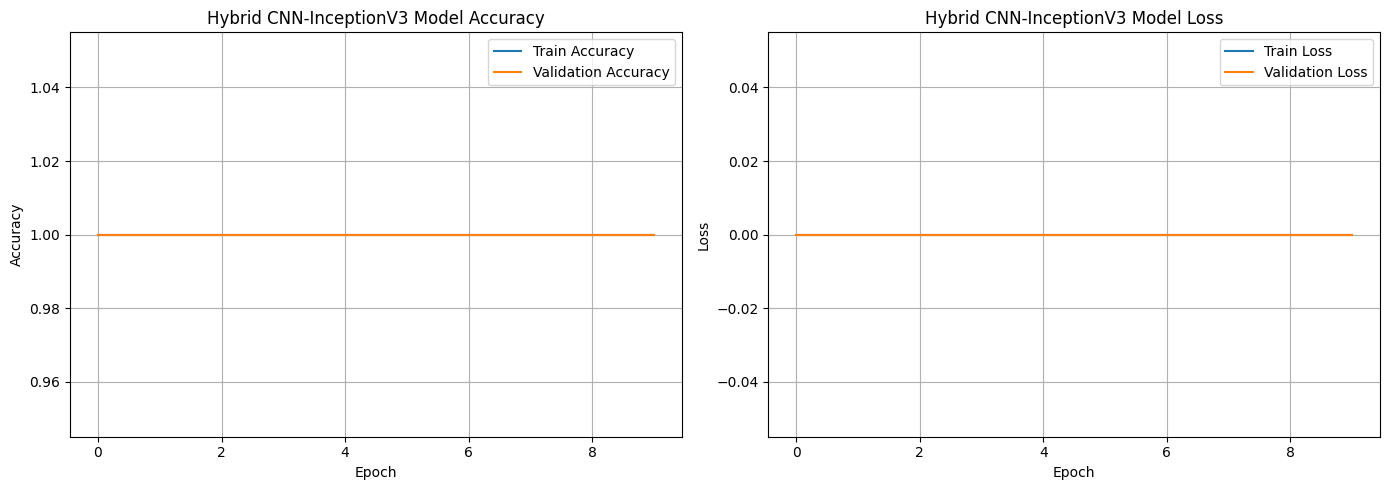

/tmp/ipython-input-497324614.py:167: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


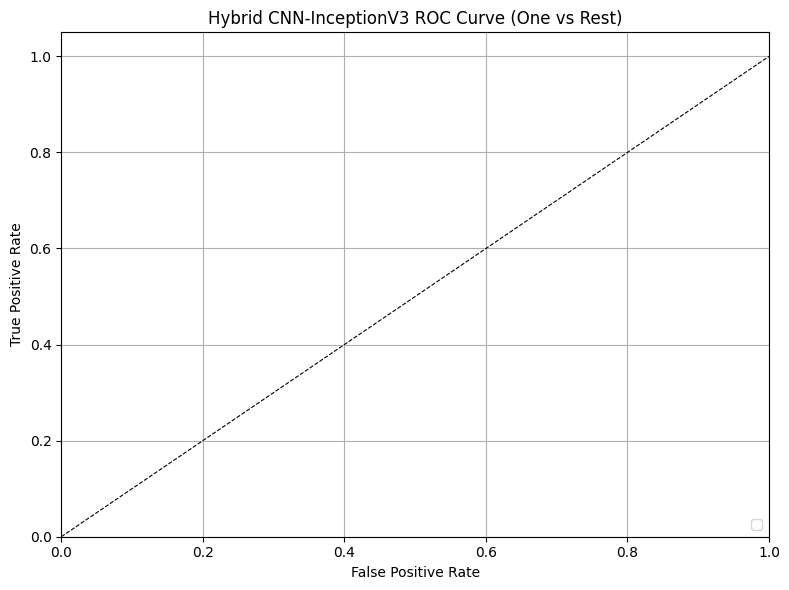

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub # Import kagglehub

# Re-defining IMG_SIZE and BATCH_SIZE to ensure they are available
IMG_SIZE = 168 # Defined in cell FPHfOXkV4otU
BATCH_SIZE = 64 # Defined in cell FPHfOXkV4otU

# Download the dataset and define 'path' within this cell
path = kagglehub.dataset_download("pes12017000148/food-ingredients-and-recipe-dataset-with-images")

dataset_images_root = os.path.join(path, 'Food Images')

# Initialize ImageDataGenerator with validation_split
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # 20% of data will be used for validation
)

train_gen = train_val_datagen.flow_from_directory(
    dataset_images_root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training'
)

val_gen = train_val_datagen.flow_from_directory(
    dataset_images_root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

num_classes = train_gen.num_classes
class_labels = list(train_gen.class_indices.keys())


# 1. Define Hybrid CNN-InceptionV3 Model
# Load the InceptionV3 model with pre-trained ImageNet weights, excluding the top (fully connected) layers
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the InceptionV3 base model
for layer in inception_base.layers:
    layer.trainable = False

# Create the new model on top of InceptionV3
hybrid_model_inceptionv3_output = inception_base.output

# Add custom convolutional layers (similar to what was done for VGG and ResNet, adjusted for Inception's typical output)
# Since InceptionV3's output is often already deep, we might add fewer custom Conv2D layers or adapt their size.
# For simplicity, let's add pooling and a dense block.
# InceptionV3 often ends with mixed layers and then average pooling. We'll add some standard CNN layers.
hybrid_model_inceptionv3_output = Conv2D(256, (3, 3), activation='relu', padding='same')(hybrid_model_inceptionv3_output)
hybrid_model_inceptionv3_output = BatchNormalization()(hybrid_model_inceptionv3_output)
hybrid_model_inceptionv3_output = MaxPooling2D(pool_size=(2, 2))(hybrid_model_inceptionv3_output)

hybrid_model_inceptionv3_output = Flatten()(hybrid_model_inceptionv3_output) # Flatten the output for the dense layers
hybrid_model_inceptionv3_output = Dense(512, activation='relu')(hybrid_model_inceptionv3_output)
hybrid_model_inceptionv3_output = Dropout(0.5)(hybrid_model_inceptionv3_output)
hybrid_model_inceptionv3_output = Dense(num_classes, activation='softmax')(hybrid_model_inceptionv3_output) # num_classes from your data generator

cnn_inceptionv3_model = Model(inputs=inception_base.input, outputs=hybrid_model_inceptionv3_output)

# 2. Compile Hybrid Model
cnn_inceptionv3_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Display the model summary
print("Hybrid CNN-InceptionV3 Model Summary:")
cnn_inceptionv3_model.summary()

# 3. Train Hybrid Model
print("\nTraining Hybrid CNN-InceptionV3 Model...")
history_hybrid_inceptionv3 = cnn_inceptionv3_model.fit(
    train_gen,
    epochs=10,  # Training for 10 epochs as per the plan
    validation_data=val_gen
)

# 4. Evaluate Hybrid Model (Confusion Matrix)
print("\nEvaluating Hybrid CNN-InceptionV3 Model...")
# Make predictions on the validation data
y_pred_proba_hybrid_inceptionv3 = cnn_inceptionv3_model.predict(val_gen)

# Get predicted classes (highest probability)
y_pred_hybrid_inceptionv3 = np.argmax(y_pred_proba_hybrid_inceptionv3, axis=1)

# Get true labels from the validation generator
y_true_hybrid_inceptionv3 = val_gen.classes

# Compute the confusion matrix
cm_hybrid_inceptionv3 = confusion_matrix(y_true_hybrid_inceptionv3, y_pred_hybrid_inceptionv3)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid_inceptionv3, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Hybrid CNN-InceptionV3 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Evaluate Hybrid Model (Classification Report)
print("\nClassification Report for Hybrid CNN-InceptionV3 Model:\n")
print(classification_report(y_true_hybrid_inceptionv3, y_pred_hybrid_inceptionv3, target_names=class_labels, zero_division=0))

# 6. Plot Accuracy and Loss Curves
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_hybrid_inceptionv3.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid_inceptionv3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN-InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid_inceptionv3.history['loss'], label='Train Loss')
plt.plot(history_hybrid_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN-InceptionV3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Plot ROC Curve
# Binarize labels for multi-class ROC (even if only one class for structural consistency)
y_true_hybrid_inceptionv3_bin = label_binarize(y_true_hybrid_inceptionv3, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))

# Loop for each class to plot ROC curve
for i in range(num_classes):
    # Check if there are true positive samples for the current class
    if np.sum(y_true_hybrid_inceptionv3_bin[:, i]) > 0:
        fpr, tpr, _ = roc_curve(y_true_hybrid_inceptionv3_bin[:, i], y_pred_proba_hybrid_inceptionv3[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
    else:
        print(f"Warning: No true samples for class '{class_labels[i]}' in validation set. Skipping ROC curve for this class.")


plt.plot([0, 1], [0, 1], 'k--', lw=0.8) # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid CNN-InceptionV3 ROC Curve (One vs Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()